# Machine learning applied to hyperspectral images <a id="top-notebook"></a>

**Authors**:
* louis.guo
* raphael.ramelet
* ilan.guenet

In this project, the goal is to develop a classification pipeline of hyperspectral images. There are two given hyperspectral images given. Those hyperspectral images were acquired by the <a href="https://en.wikipedia.org/wiki/Airborne_visible/infrared_imaging_spectrometer">AVIRIS sensor</a>. The specifications are 224 bands between 0.4μm to 2.5μm with a 10nm band width.

On these images, there are 16 different categories and a classifier classifying the pixels of the images must be found. The classifier must be the most **accurate** and the most **generic**. Deep learning is also forbidden (for educational purposes).

Many experiments will be performed in order to find the best classifiers with **preprocessing**, **transformers**, and **searching** of the best classifier.


**Table of content**:
* [Load data](#load-data)
* [Preprocessing](#preprocessing)
    * [Gaussian blur](#gaussian-blur)
* [Transformers](#transformers)
    * [Reshape inputs](#reshape-input)
    * [Standard Scaler](#standard-scaler)
    * [Dimension reduction (PCA)](#dimension-reduction)
    * [SelectKBest](#selectkbest)
* [Classification API](#classification-api)
    * [Grid search with cross-validation](#grid-search)
    * [Evaluation](#api-evaluation)
* [Multiclass classification](#multiclass-classification)
    * [With other VS without other](#with-vs-without)
        * [LinearSVC](#linear-svc-1)
        * [RandomForest](#random_forest-1)
    * [Indiana classification (bench)](#bench-classifier-indiana)
        * [LinearSVC (One Versus All)](#linear-svc-2)
        * [RandomForest (Inherently multiclass)](#random_forest-2-indiana)
        * [K-nearest neighbors (Inherently multiclass)](#k-nearest-2)
        * [SVC (One Versus One)](#svc-2-indiana)
        * [Recap of indiana classifiers](#recap-indiana)
    * [Salinas classification](#salinas-classification)
        * [SVC (One Versus One)](#svc-2-salinas)
        * [RandomForest (Inherently multiclass)](#random_forest-2-salinas)
        * [Recap of salinas classifiers](#recap-salinas)
* [Impact of the gaussian blur](#impact-gauss-blur)
* [Performance of the best classifier](#performance-best-classifier)
* [Tasks distribution](#tasks-distribution)


**Resources**:
* Pre-processing of hyperspectral images. Essential steps before image analysis by Maider Vidal (<a href="https://www.researchgate.net/publication/236244862_Pre-processing_of_hyperspectral_images_Essential_steps_before_image_analysis">link</a>)
* Scikit-learn documentation (<a href="https://scikit-learn.org/stable/">link</a>)
* IML course from EPITA

Import python depedencies. Remember to run ```pip install -r requirements.txt``` before running the notebook

In [96]:
# !pip install -r requirements

# If using pip3
# !pip3 install -r requirements.txt

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import seaborn as sn

# Save models
from joblib import dump, load

%matplotlib inline

# Pretty pretting of sklearn classifiers
sk.set_config(display='diagram')

random_state = 2727

## Load data <a id="load-data"></a>
[Table of content](#top-notebook)

### Hyperspectral image

In [98]:
!ls data/

indianapines_gt.npy  indianapines.npy  salinas_gt.npy  salinas.npy


In [99]:
X_indiana = np.load("data/indianapines.npy").astype('float32')
X_indiana.shape, X_indiana.dtype, np.min(X_indiana), np.max(X_indiana)

((145, 145, 200), dtype('float32'), 955.0, 9604.0)

In [100]:
X_salinas = np.load("data/salinas.npy").astype('float32')
X_salinas.shape, X_salinas.dtype, np.min(X_salinas), np.max(X_salinas)

((512, 217, 204), dtype('float32'), -11.0, 9207.0)

In [101]:
def plot_rgb(im, title=None):
    """
    Plot a hyperspectral image as an RGB image
    
    Parameters
    ----------
    im : numpy.ndarray
        The hyperspectral image as a ndarray.
    title: str
        Title of the image
    """
    rgb_bands = np.array([30, 15, 2])
    im_rgb = im[:,:,rgb_bands]

    pmin, pmax = np.percentile(im_rgb, (1,99), axis=(0,1))
    
    for i in range(pmin.size):
        # Normalize
        im_rgb[:,:,i] = (im_rgb[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])
        
    im_rgb[im_rgb<0] = 0
    im_rgb[im_rgb>1] = 1
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(im_rgb)
    plt.plot()

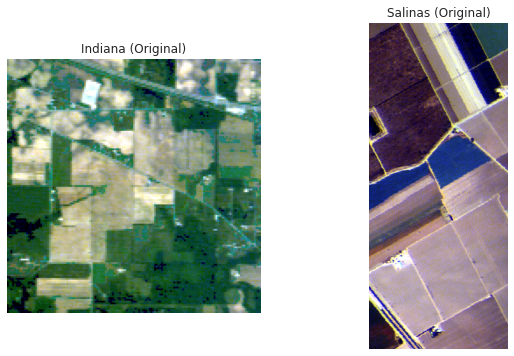

In [102]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plot_rgb(X_indiana, "Indiana (Original)")
plt.subplot(122)
plot_rgb(X_salinas, "Salinas (Original)")
plt.show()

The two hyperspectral images look **different**:
* **Their shape** is different. The indiana image has a shape of (145, 145) and the salinas image has a shape of (512, 217). The salinas image has five times more pixels than the indiana image.
* **The number of bands** is different. The indiana image has 200 bands. On the other hand, the salinas image has 204 bands. When the hyperspectral image is acquired, some of the bands may be corrupted. Those corrputed bands are not saved. It explains the difference of number of band between the two hyperspectral images. The salinas image has less corrupted bands. 
* As the two hyperspectral images were taken in **two different sites**, the objects on the ground are different. It can be seen with the difference of color. The indiana image look more green and the salinas image look more blue.
    
Luckily, the **data type** is the same (float32).

### Load labels

In [103]:
y_indiana = np.load("data/indianapines_gt.npy")
y_indiana.shape, y_indiana.dtype, np.min(y_indiana), np.max(y_indiana)

((145, 145), dtype('uint8'), 0, 16)

In [104]:
y_salinas = np.load("data/salinas_gt.npy")
y_salinas.shape, y_salinas.dtype, np.min(y_salinas), np.max(y_salinas)

((512, 217), dtype('uint8'), 0, 16)

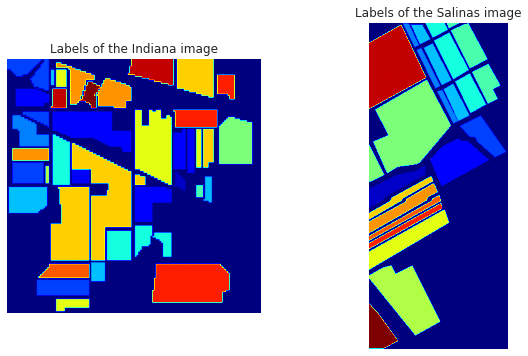

In [105]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.imshow(y_indiana, cmap='jet')
plt.title("Labels of the Indiana image")
plt.axis("off")


plt.subplot(122)
plt.imshow(y_salinas, cmap='jet')
plt.title("Labels of the Salinas image")
plt.axis("off")

plt.show()

Every images has 17 categories. Category 0 is considered as a non-category. This category is going to be called `Other` from now on. Also, the other category seems to be the main category which means many pixels are actually not labelled.

Even if the two images has the same number of categories, the categories between the two images are not related.

### Dictionary label to category

<table>
    <tr><th>Categories from Indiana</th>
        <th>Categories from Salinas</th>
    </tr>
    <tr><td>
    
| # | Category name |
|---|-------|
| 0 | Other |
| 1 | Alfalfa |
| 2 | Corn-notill |
| 3 | Corn-mintill |
| 4 | Corn |
| 5 | Grass-pasture |
| 6 | Grass-trees |
| 7 | Grass-pasture-mowed |
| 8 | Hay-windrowed |
| 9 | Oats |
| 10 | Soybean-notill |
| 11 | Soybean-mintill |
| 12 | Soybean-clean |
| 13 | Wheat |
| 14 | Woods |
| 15 | Buildings-Grass-Trees-Drives |
| 16 | Stone-Steel-Towers |
    
</td><td>
    
| # | Category name |
|---|-------|
| 0 | Other |
| 1 | Brocoli_green_weeds_1 |
| 2 | Brocoli_green_weeds_2 |
| 3 | Fallow |
| 4 | Fallow_rough_plow |
| 5 | Fallow_smooth |
| 6 | Stubble |
| 7 | Celery |
| 8 | Grapes_untrained |
| 9 | Soil_vinyard_develop |
| 10 | Corn_senesced_green_weeds |
| 11 | Lettuce_romaine_4wk |
| 12 | Lettuce_romaine_5wk |
| 13 | Lettuce_romaine_6wk |
| 14 | Lettuce_romaine_7wk |
| 15 | Vinyard_untrained |
| 16 | Vinyard_vertical_trellis |
    
</td></tr>
</table>

In [106]:
label_to_category = dict()

label_to_category['indiana'] = {  0: "Other",
                                  1: "Alfalfa",
                                  2: "Corn-notill",
                                  3: "Corn-mintill",
                                  4: "Corn",
                                  5: "Grass-pasture",
                                  6: "Grass-trees",
                                  7: "Grass-pasture-mowed",
                                  8: "Hay-windrowed",
                                  9: "Oats",
                                 10: "Soybean-notill",
                                 11: "Soybean-mintill",
                                 12: "Soybean-clean",
                                 13: "Wheat",
                                 14: "Woods",
                                 15: "Buildings-Grass-Trees-Drives",
                                 16: "Stone-Steel-Towers"}

label_to_category['salinas'] = { 0: 'Other',
                                 1: 'Brocoli_green_weeds_1',
                                 2: 'Brocoli_green_weeds_2',
                                 3: 'Fallow',
                                 4: 'Fallow_rough_plow',
                                 5: 'Fallow_smooth',
                                 6: 'Stubble',
                                 7: 'Celery',
                                 8: 'Grapes_untrained',
                                 9: 'Soil_vinyard_develop',
                                10: 'Corn_senesced_green_weeds',
                                11: 'Lettuce_romaine_4wk',
                                12: 'Lettuce_romaine_5wk',
                                13: 'Lettuce_romaine_6wk',
                                14: 'Lettuce_romaine_7wk',
                                15: 'Vinyard_untrained',
                                16: 'Vinyard_vertical_trellis'}

len(label_to_category), len(label_to_category['indiana']), len(label_to_category['salinas'])

(2, 17, 17)

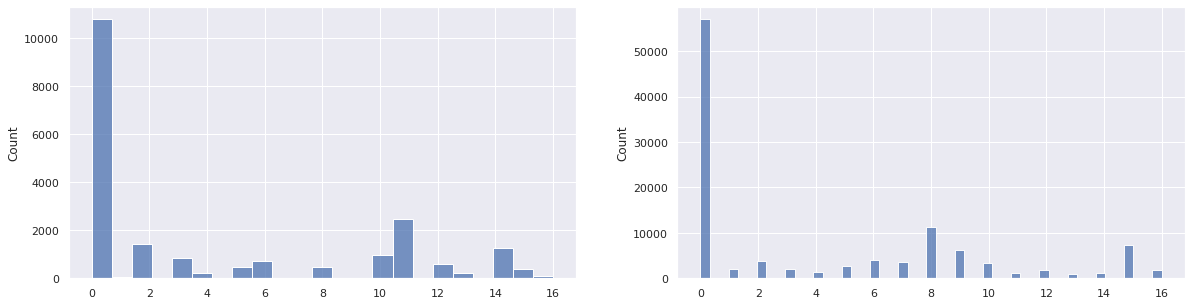

In [107]:
plt.figure(figsize=(20,5))

plt.subplot(121)
ax_indiana = sn.histplot(y_indiana.flatten())

plt.subplot(122)
ax_salinas = sn.histplot(y_salinas.flatten())

plt.show()

In the two hyperspectral images, the categories are strongly unbalanced and the dominant category is the Other category.

## Preprocessing <a id="preprocessing"></a>

[Table of content](#top-notebook)

### Gaussian blur <a id="gaussian-blur"></a>

[Table of content](#top-notebook)

Let's see first the impact of a gaussian blur on rgb images.

The multi-dimensional filter is implemented as a **sequence of one-dimensional convolution filters**.

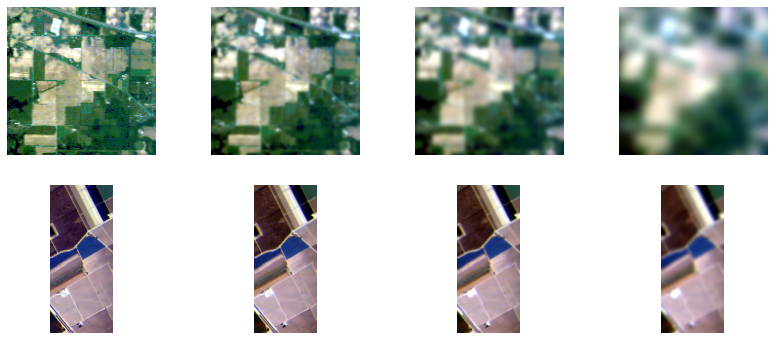

In [108]:
from skimage.filters import gaussian
plt.figure(figsize=(14,6))

# Indiana
plt.subplot(241)
plot_rgb(X_indiana)
plt.subplot(242)
plot_rgb(gaussian(X_indiana, sigma=1, multichannel=True))
plt.subplot(243)
plot_rgb(gaussian(X_indiana, sigma=2, multichannel=True))
plt.subplot(244)
plot_rgb(gaussian(X_indiana, sigma=5, multichannel=True))

# Salinas
plt.subplot(245)
plot_rgb(X_salinas)
plt.subplot(246)
plot_rgb(gaussian(X_salinas, sigma=1, multichannel=True))
plt.subplot(247)
plot_rgb(gaussian(X_salinas, sigma=2, multichannel=True))
plt.subplot(248)
plot_rgb(gaussian(X_salinas, sigma=5, multichannel=True))

Why a gaussian blur may be useful as a preprocessing step. According to <a href="https://www.researchgate.net/publication/236244862_Pre-processing_of_hyperspectral_images_Essential_steps_before_image_analysis">Pre-processing of hyperspectral images. Essential steps before image analysis</a>, `De-noising: The instrumental noise can be partly removed by using smoothing techniques.` The given hyperspectral images have noise. This is instrumental noise that is acquired during the photo taking. One way to remove that noise is to apply a blur over the images.

A gaussian blur with a sigma of 5 will be applied to the input data. This value does not come out of nowhere. Later in the notebook, it is going to be proven that it the optimal value.

In [109]:
X_indiana_blur = gaussian(X_indiana, sigma=5, multichannel=True)
X_salinas_blur = gaussian(X_salinas, sigma=5, multichannel=True)

Let's plot the noise of some band and see how well works a gaussian blur over them.

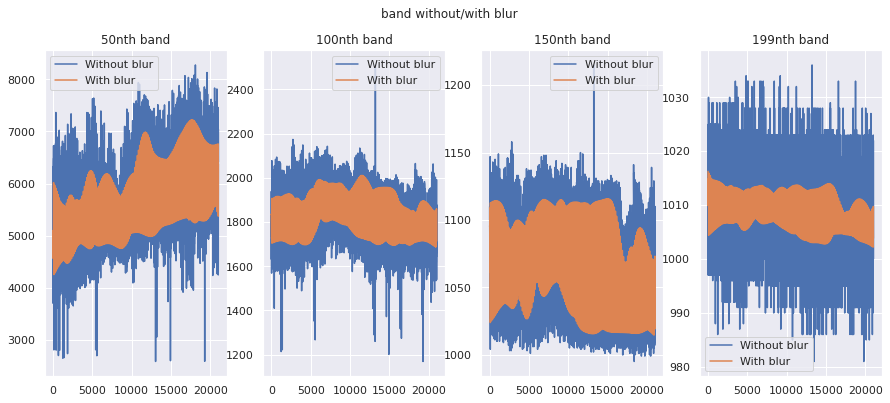

In [110]:
fig = plt.figure(figsize=(15, 6))
plt.suptitle("band without/with blur")
plt.subplot(141)
plt.title("50nth band")
plt.plot(X_indiana[:, :, 50].flatten())
plt.plot(X_indiana_blur[:, :, 50].flatten())
plt.legend(["Without blur", "With blur"])

plt.subplot(142)
plt.title("100nth band")
plt.plot(X_indiana[:, :, 100].flatten())
plt.plot(X_indiana_blur[:, :, 100].flatten())
plt.legend(["Without blur", "With blur"])

plt.subplot(143)
plt.title("150nth band")
plt.plot(X_indiana[:, :, 150].flatten())
plt.plot(X_indiana_blur[:, :, 150].flatten())
plt.legend(["Without blur", "With blur"])


plt.subplot(144)
plt.title("199nth band")
plt.plot(X_indiana[:, :, 199].flatten())
plt.plot(X_indiana_blur[:, :, 199].flatten())
plt.legend(["Without blur", "With blur"])

plt.show()

As it can be seen above, in blue there are a lot of noise (the visible spikes). The gaussian blur works well because those spikes are "smoothed". In orange, the curves are much smoother. The noise disapeared. By applying a gaussian blur, hyperspectral images will be **less affected by the noise** and thus be more accurate when trying to classify.


## Transformers <a id="transformers"></a>

[Table of content](#top-notebook)

### Reshape inputs<a id="reshape-input"></a>

[Table of content](#top-notebook)


In [111]:
X_indiana_blur = gaussian(X_indiana, sigma=5, multichannel=True)
X_salinas_blur = gaussian(X_salinas, sigma=5, multichannel=True)

In [112]:
# The classifiers requires a 2D matrix.
indiana_row, indiana_col, indiana_dim = X_indiana.shape
X_indiana = X_indiana.reshape((-1, indiana_dim))
X_indiana_blur = X_indiana_blur.reshape((-1, indiana_dim))


y_indiana = y_indiana.flatten()
X_indiana.shape, y_indiana.shape

((21025, 200), (21025,))

In [113]:
# Same for salinas
salinas_row, salinas_col, salinas_dim = X_salinas.shape
X_salinas = X_salinas.reshape((-1, salinas_dim))
X_salinas_blur = X_salinas_blur.reshape((-1, salinas_dim))

y_salinas = y_salinas.flatten()
X_salinas.shape, y_salinas.shape

((111104, 204), (111104,))

### Standard scaler <a id="standard-scaler"></a>

[Table of content](#top-notebook)

Standardize the features by substracting the mean and dividing the variance such that:
$$ x_{new} = \frac{x - u}{s} $$

In machine learning, it is better to scale the data to look like a standard normal distributed data. According to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">scikit-learn</a>: `For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order`. Some algorithms assume the data are standardized. Thus, this is a must-do step.

<ipython-input-114-71ea6a74cf3e>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


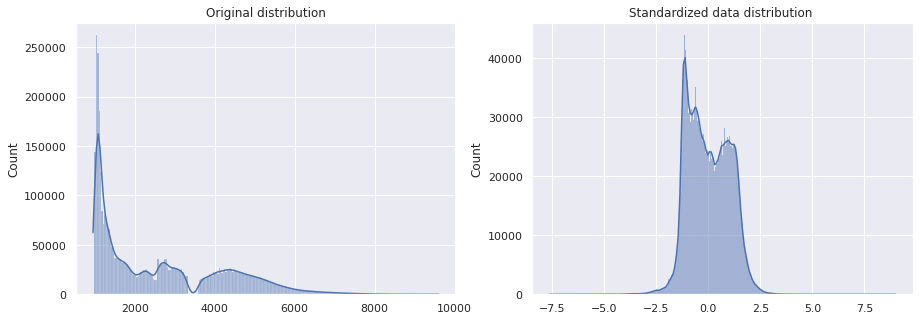

In [114]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Compute mean and variance
scaler.fit(X_indiana)

# Standardize data
scaled_indiana = scaler.transform(X_indiana)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sn.histplot(X_indiana.flatten(), ax=axes[0], kde=True)
axes[0].set_title("Original distribution")

sn.histplot(scaled_indiana.flatten(), ax=axes[1], kde=True)
axes[1].set_title("Standardized data distribution ")
fig.show()

### Dimension reduction (PCA)<a id="dimension-reduction"></a>

[Table of content](#top-notebook)

Machine learning is more efficient with lower dimensions. The hyperspectral image have at least 200 dimensions. That seems way too large for any machine learning algorithm. Thus, we are going to reduce the dimension of the problem using the **P**rincipal **C**omponents **A**nalysis (**PCA**) algorithm.

Documentation:
* <a href=https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>scikit-learn PCA</a>


#### Setup PCA

In [115]:
from sklearn.decomposition import PCA

pca = PCA(random_state=random_state)
pca

PCA(random_state=2727)

In [116]:
pca.fit(X_indiana)

PCA(random_state=2727)

#### Analyse PCA

In [117]:
print(f"Number of components: {pca.n_components_} (equals to number of wavelength)")

Number of components: 200 (equals to number of wavelength)


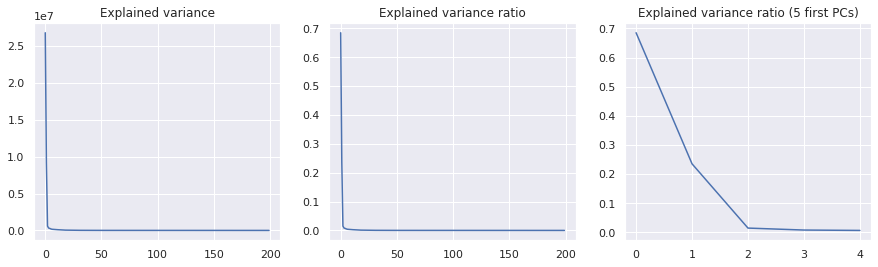

In [118]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(pca.explained_variance_)
plt.title("Explained variance")

plt.subplot(1, 3, 2)
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance ratio")

plt.subplot(1, 3, 3)
plt.plot(pca.explained_variance_ratio_[:5])
plt.title("Explained variance ratio (5 first PCs)")

plt.show()

In [119]:
print(f"The first component explains {np.floor(pca.explained_variance_ratio_[0] * 100)}% of the variance")
print(f"The second component explains {np.floor(pca.explained_variance_ratio_[1] * 100)}% of the variance")

The first component explains 68.0% of the variance
The second component explains 23.0% of the variance


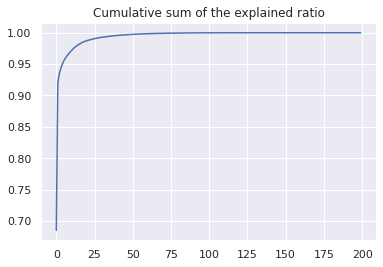

In [120]:
var_cumsum = pca.explained_variance_ratio_.cumsum()

plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

The first principal components explains most of the variance. It is not needed to keep the last principal components. They usually hold the information of noise. As we want to reduce the dimensions, only the first principal components are going to be used to project data into a new space.

#### Make decision

How many principal components are we going to use to project data? We want to project the data in a way that at least a percentage (threshold) of the variance (information) is preserved. This information can be found from the cumulative sum of the expained variance. We pick as many principal components until their total explained variance is greater than the threshold.

In [121]:
threshold = 0.95 # 95%

# Number of selected principal components such as the cumulative sum of the explained 
# variance ratio of these principal components is at least greater than the threshold 
nb_pc = np.where(var_cumsum>threshold)[0][0] + 1
print('%d principal components explains at least %1.2f%% of the \
variance.'%(nb_pc, threshold * 100))

5 principal components explains at least 95.00% of the variance.


In [122]:
pca_params = {"n_components" : nb_pc}
pca = pca.set_params(**pca_params)

# We need to fit again to use the new params 
pca.fit(X_indiana)

PCA(n_components=5, random_state=2727)

#### Projection

In [123]:
# Projection of the data into the new basis from the PCA
Xproj = pca.transform(X_indiana)
Xproj = Xproj.reshape((indiana_row, indiana_col, nb_pc))
Xproj.shape

(145, 145, 5)

The hyperspectral image is projected from 200 dimensions to the number of PC dimensions (5 if 95% is the threshold). Thus, the number of dimensions is strongly reduced.

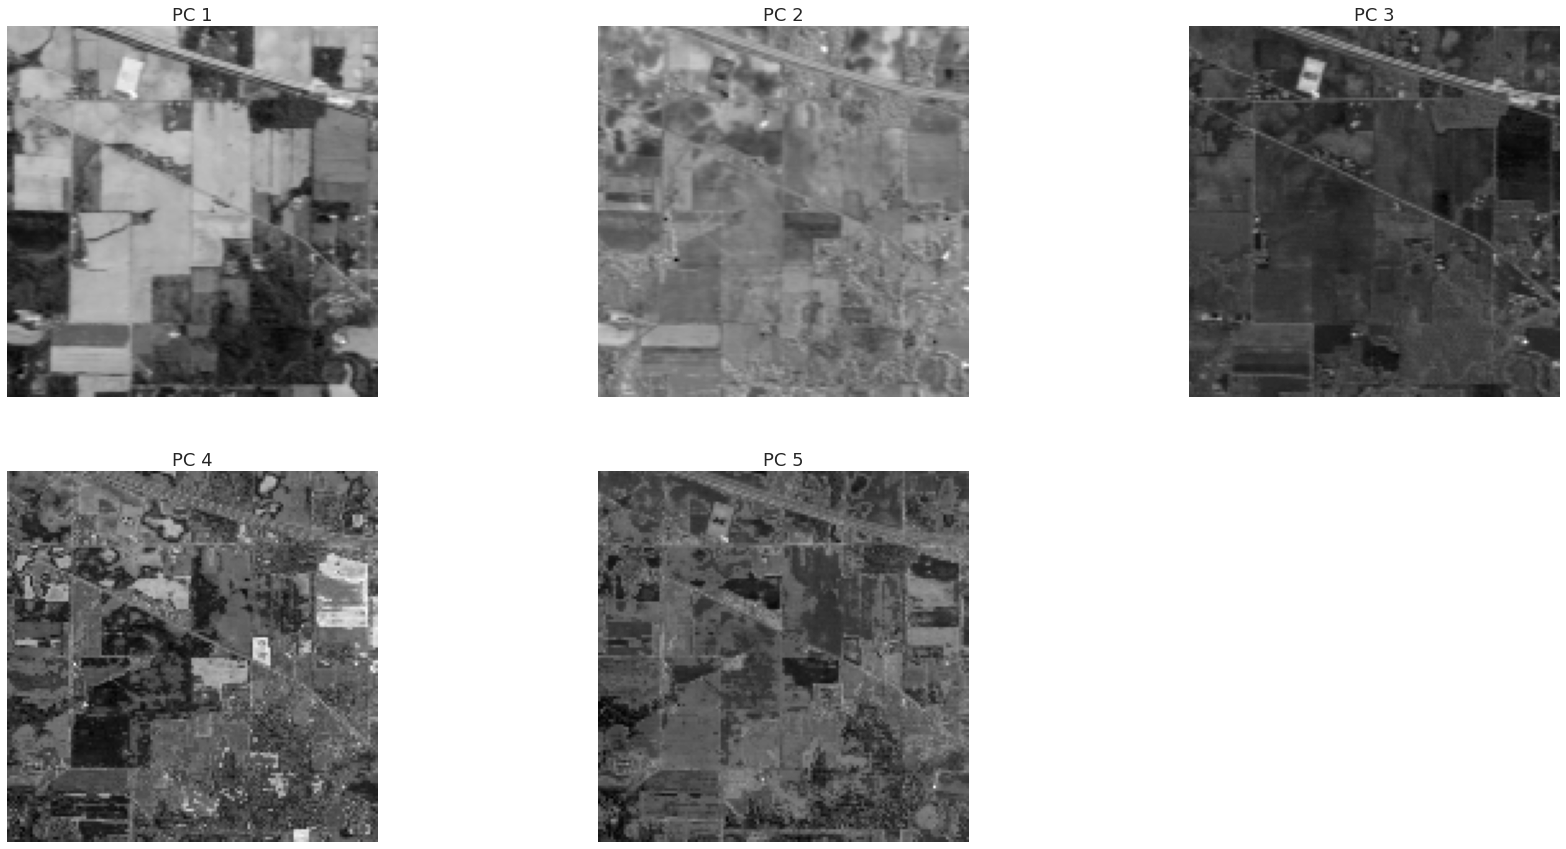

In [124]:
# Plot the information of each principal components

plt.figure(figsize=(30,15))
for i in range(nb_pc):
    plt.subplot(int(nb_pc / 3) + 1, 3, i+1)
    plt.title('PC %d'%(i+1), fontsize=18)
    plt.axis('off')
    plt.imshow(Xproj[:,:,i], cmap='gray')
plt.show()

In [125]:
Xproj_back = pca.inverse_transform(Xproj)
Xproj_back.shape # The shape is back to the original image

(145, 145, 200)

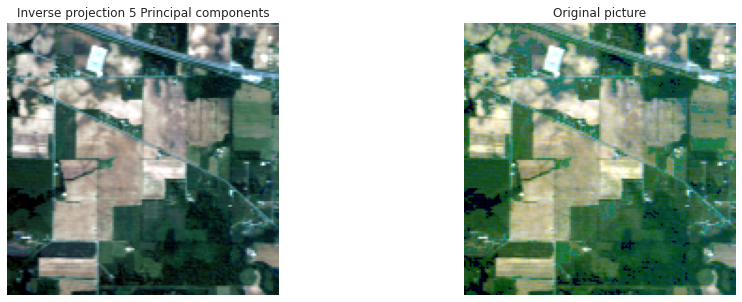

In [126]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plot_rgb(Xproj_back,
         "Inverse projection " + str(nb_pc) + " Principal components")

plt.subplot(1,2,2)
plot_rgb(X_indiana.reshape(indiana_row, indiana_col, indiana_dim),
         "Original picture")

plt.show()

#### Extra information

##### Mean Square Error (MSE)

In [127]:
def MSE(im1,im2):
    if im1.ndim > 2:
        im1 = im1.reshape((-1,im1.shape[2]))
    if im2.ndim > 2:
        im2 = im2.reshape((-1,im2.shape[2]))
    mse = ((im1-im2)**2).sum(axis=1).mean()
    return mse

MSE(Xproj_back, X_indiana)

1941170.2

In [128]:
# Create a range of number of principal components to use for each PCA
nb_pc_range = np.unique(np.round(np.geomspace(1, 190, num=20))).astype(int)
nb_pc_range

array([  1,   2,   3,   4,   5,   7,   9,  12,  16,  21,  27,  36,  48,
        63,  83, 109, 144, 190])

In [129]:
mse_seq = []
for nb_pc_curr in nb_pc_range:
    pca_mse = PCA(n_components = nb_pc_curr, random_state = random_state)
    
    # Fit and transform
    testproj = pca_mse.fit_transform(X_indiana)
    # Inverse transform
    testproj_back = pca_mse.inverse_transform(testproj)
    testproj_back = testproj_back.reshape((indiana_row, indiana_col, indiana_dim))
    # Compute MSE
    mse_seq.append(MSE(testproj_back, X_indiana))

mse_seq = np.array(mse_seq)

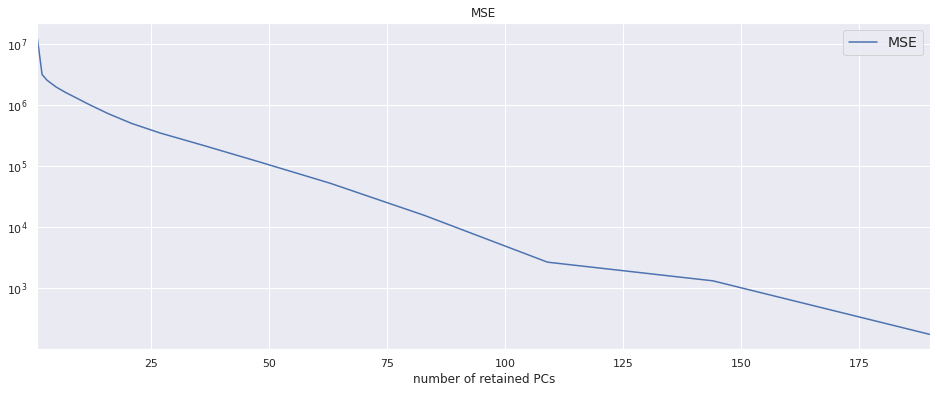

In [130]:
plt.figure(figsize=(16,6))

plt.plot(nb_pc_range, mse_seq, 'b', label='MSE')
plt.xlim(nb_pc_range[0], nb_pc_range[-1])
plt.xlabel('number of retained PCs')
plt.yscale('log')
plt.legend(loc='best', fontsize=14)
plt.title('MSE')
plt.show()

The MSE is lower when the number of retained PCs is greater. It means the error is lower with a greater number of PCs. However, with a few PCs the error might be already low enough.

#### Thresholds

Function to get the number of principal components to use according to a threshold of the explained variance. This function is needed during a grid search (later used in the notebook).

In [131]:
def get_pca_components(X, thresholds=[0.95, 0.99, 0.999, 0.9999]):
    """
    Get the number of components for each threshold
    
    Parameters
    ----------
    X: numpy.ndarray
        The input data
    thresholds: list
        List of thresholds
        
    Returns
    -------
    list
        List of number of components for each given threshold
    """

    pca = PCA(random_state=random_state)
    pca.fit(X)
    param_n_components = []
    for threshold in thresholds:
        var_cumsum = pca.explained_variance_ratio_.cumsum()
        param_n_components.append(np.where(var_cumsum>threshold)[0][0] + 1)
    
    return param_n_components

### Select K best <a id="selectkbest"></a>

[Table of content](#top-notebook)

Select the k best features. It might be useful to keep track of the overall most representing features. A score is computed for every features. The features with the highest scores mean they hold more information. Thus, those features are more relevant for the classification.

In [132]:
from sklearn.feature_selection import SelectKBest

select_kbest = SelectKBest(k=1)
select_kbest.fit(X_indiana, y_indiana)

SelectKBest(k=1)

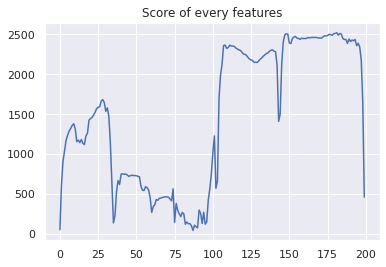

In [133]:
plt.plot(select_kbest.scores_)
plt.title("Score of every features")
plt.show()

In the case of the indiana hyperspectral image, it can be seen that features have different scores. Thus, features have different impacts for the classification. For instance, features between 50 and 100 are poorly relevant compared to the features between 100 and 200. However, the top scores are all close to each other. It **does not seem to be relevant** to use this feature extractor because we would select some features, but missing a lot of information by not using the other one.

## Classification API <a id="classification-api"></a>

[Table of content](#top-notebook)

In this section, a few functions are implemented for conveniency, factorization and cleaness of the code. Moreover, the usage of a sklearn classifier is the same no matter the classifier.

### Grid search with cross-validation<a id="grid-search"></a>
[Table of content](#top-notebook)

A classifier may have several hyperparameters. The goal is to find the best classifier with the best hyperparameters for a given problem. The grid search performs a exhaustive search over specified hyperparameters.

Workflow:
1. Create **classifier**
2. Create the list of **hyperparameters**
3. **Search** the best classifier (fit step). Try every combination of hyperparameters. For each combination, split the train data into 80% of **train data** and 20% of **validation data**. Fit with the train data. Score the classifier with the validation data. Repeat this 5 times for each combination until the whole data was covered by the validation data. Compute the mean score for each combination. Return the combination with the best score.
4. Compute the **score** of the classifier with the best hyperparameters over the test data.

documentation:
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">scikit-learn GridSearchCV</a>

In [134]:
from sklearn.model_selection import GridSearchCV

# / Positional argument before
# * Must name the parameter
def grid_search(clf, X, y, grid_params, /, *, n_jobs=-1, verbose=4):
    """
    Perform a grid search with cross validation
    
    Parameters
    ----------
    clf : classifier
        The classifier performing the grid search
    X: numpy.ndarray
        The input data
    y: numpy.ndarray
        The labels
    grid_params: dict
        The grid parameters. It must follow this syntax
        Key = step name from pipeline + __ + hyperparameter
        Value = tuple or list of possible values
        i.e. the name of the PCA classifier is pca:
        'pca__n_components': [1, 2, 5, 10]
    n_jobs: int, default=-1
        Number of jobs performing the grid search
    verbose: int, default=4
        Level of verbosity
        
    Returns
    -------
    dict
        Best parameters for the given classifier found by the search
    """
    
    # Create the gridsearch
    # Cross validation gridsearch
    gs = GridSearchCV(clf, grid_params, n_jobs=n_jobs, verbose=4)
    print("---- Start search ----")
    gs.fit(X, y)
    print("---- Search finished ----")
    print("Best parameter (CV score=%0.3f): " % gs.best_score_)
    print(gs.best_params_)
    return gs.best_params_

In the above function, the grid search is performed through a classifier. Scikit-learn gives a way to create a special kind of classifier called **Pipelines** (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">scikit-learn</a>). A pipeline consists of a sequence of transforms with a final estimator. The behavior is the same as a classifier but it also applied beforehand some transformation to the input data.

For instance, here is the workflow of a pipeline with a PCA (transform) then the classifier LinearSVC.

1. **Training**
    1. `PCA.fit(X_train)` --> fit the transform
    2. `Xproj = pca.transform(X_train)` --> transform the training input
    3. `LinearSVC.fit(Xproj, y_train)` --> fit the final estimator
2. **Test/Validation**
    1. `Xproj_test = pca.tranform(X_test)` --> transform the test input
    2. `LinearSVC.predict(Xproj_test, y_test)` --> predict the test input

The pipeline is very useful to not forget any steps of the transformation sequence. It is also very convenient to use.

### Evaluation <a id="api-evaluation"></a>
[Table of content](#top-notebook)


#### Confusion matrix
A confusion matrix usage is to evaluate the quality of the predictions of a classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The true labels are represented by the rows and the predictions by the columns.

Documentation:
 * scikit-learn documentation of confusion matrix <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html">here</a>.

In [135]:
from sklearn.metrics import confusion_matrix

def my_plot_confusion_matrix(conf_matrix, classes, title=None, figsize=(10,5)):
    """
    Plot the confusion matrix
    
    Parameters
    ----------
    conf_matrix : numpy.ndarray
        A computed confusion matrix
    classes: list
        Names of the categories/classes
    title: str, default=None
        Title of the plot
    figsize: tuple (int, int)
        Size of the figure
    """
    df_cm = pd.DataFrame(conf_matrix, classes, classes)
    plt.figure(figsize=figsize)
    sn.set(font_scale=1) # for label size
    ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g', annot_kws={"size": 11}) # font size
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    if title:
        plt.title(title)
    else:
        plt.title("Confusion matrix")
    ax.plot([1, 0], [0, 1], linewidth=0.2, color='black', transform=ax.transAxes)

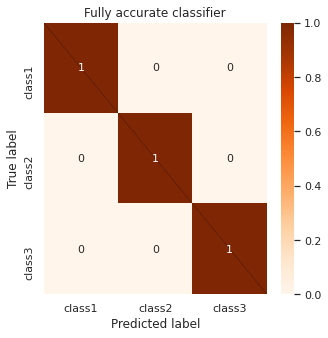

In [136]:
# Example of a confusion matrix
example_classes = ['class1', 'class2', 'class3']
example_val = np.identity(3)
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate classifier", figsize=(5,5))

In [137]:
from sklearn.metrics import classification_report

def my_classification_report(clf, X, y, shape, classes, clf_name=None):
    """
    Display a report of a given classifier for a labelled input
    
    Parameters
    ----------
    clf : classifier
        The classifier to report
    X: numpy.ndarray
        Data used for the report
    y: numpy.ndarray
        Labels of the data
    shape: tuple
        2D shape of the data
    classes: list
        Names of the categories/classes
    clf_name: str
        Name of the classifier
    """
    y_pred = clf.predict(X)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Plot confusion matrix
    title=None
    if clf_name:
        title = "Confusion matrix with " + clf_name + " classifier."
    my_plot_confusion_matrix(conf_matrix, classes, title)
    
    # Classification report
    print(classification_report(y, y_pred, target_names=classes))

#### Scores

The **accuracy** is computed this way: $$Accuracy = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} $$



The **precision** for a class is the number of correctly predicted images of this class out of all predicted images of this class.

The **recall** for a class is the number of correctly predicted images of this class out of the number of actual images of this class.

The **f1-score** is the combination of the precision score and recall score such that $$\text{f1 score} = 2\frac{\text{precision}  \times \text{recall}}{\text{precision} + \text{recall}}$$ It tries to compromise the precision with the recall.

The f1-score can be computed in two different ways for more way of result interpretation:
* **macro**: Calculate metrics for each label and compute the unweighted mean. This does **not** take label imbalance into account
* **weighted**: Calculate metrics for each label and compute the average weighted by support (the number of true instances for each label).

The closer these scores get to 1, the more accurate the classifier is.

The blue rectangle represents the recall of class1
The green rectangle represents the precision of class1


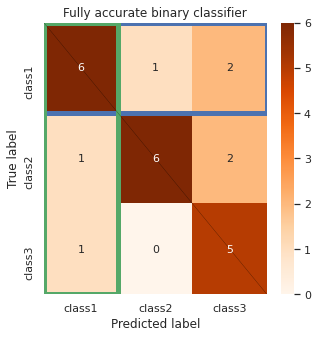

In [138]:
import matplotlib.patches as patches

# Display the recall and precision on a confusion matrix

example_val = np.array([[6, 1, 2], [1, 6, 2], [1, 0, 5]])
my_plot_confusion_matrix(example_val, example_classes, title="Fully accurate binary classifier", figsize=(5,5))
ax = plt.gca()
# Add the patch to the Axes
ax.add_patch(patches.Rectangle((0, 0), 3, 1, linewidth=5, edgecolor='b', facecolor='none'))
ax.add_patch(patches.Rectangle((0, 0), 1, 3, linewidth=5, edgecolor='g', facecolor='none'))
print("The blue rectangle represents the recall of class1")
print("The green rectangle represents the precision of class1")

In [139]:
from sklearn.metrics import f1_score

def evaluate_clf(clf, X_test, y_test, must_print=True):
    """
    Evaluate a classifier
    
    Compute and print the accuracy, f1 macro score and f1 weighted score
    of the classifier
    
    Parameters
    ----------
    clf : classifier
        The classifier to evaluate. The classifier must have already fit.
    X_test: numpy.ndarray
        Test data
    y_test: numpy.ndarray
        Labels of the test data
    must_print: boolean
        Flag whether to print scores
    """
    
    # Accuracy
    score = clf.score(X_test, y_test)
    
    # f1 macro
    y_pred = clf.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # f1 weighted
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Print scores
    if must_print:
        print("Score: %0.3f." % score)
        print("f1 macro score: %0.3f." % f1_macro)
        print("f1 weighted score: %0.3f." % f1_weighted)
    
    return score, f1_macro, f1_weighted

## Multiclass classification<a id="multiclass-classification"></a>

[Table of content](#top-notebook)

How are we going to solve the given problem. Let's take a look at the `scikit-learn algorithm cheat-sheet`. It shows the steps we need to be aware of when choosing an algorithm in order to resolve a machine learning problem. This way, a lot of missteps can be avoided.

![all text](https://scikit-learn.org/stable/_static/ml_map.png)

1. Begin from `START`
2. Are there more than 50 samples? Answer: yes, it is not required to get more data.
3. Do we want to predict a category? Answer: yes, the category of each pixels must be predicted.
4. Are the data labeled? Answer: yes, the two images comes with their respective labels.
5. It is a **problem of classification**.

In this section, the best predicter of classes is going to be search. In the first part, we will see how to **upgrade** the dataset by removing a category. Then, we are going to **search** the best classifier respectively for the Indiana hyperspectral image and Salinas hyperspectral image.

In [140]:
from sklearn.pipeline import Pipeline

### With other VS without other<a id="with-vs-without"></a>

[Table of content](#top-notebook)

In this section, the impact of the `other` category is checked. The data are strongly unbalanced especially with this category. As a reminder, this category means a lack of labelling. We want to avoid as much as possible bad accuracy because of it.

The checking will be processed this way:
1. Test classifiers accuracy **including** the `other` category
2. Test classifiers accuracy **excluding** the `other` category

The problem of the other category `other` can be found in every input (indiana and salinas). The verification is only performed with the indiana image. The result of this experience with any other image would be the same. Thus, it is not required to test over all the given images.

Separate the indiana data into two datasets. The first one includes the pixel labelled as `other`. The second one excludes them.

In [141]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_indiana_blur, 
                                                                        y_indiana, 
                                                                        test_size=0.15,
                                                                        random_state=random_state)

X_train_with.shape, y_train_with.shape, X_test_with.shape, y_test_with.shape

((17871, 200), (17871,), (3154, 200), (3154,))

In [142]:
# Remove pixels with the unknown category (category 0)
without_indices_indiana = np.where(y_indiana!=0)[0]
X_indiana_without = X_indiana_blur[without_indices_indiana]
y_indiana_without = y_indiana[without_indices_indiana]
X_indiana_without.shape, y_indiana_without.shape

((10249, 200), (10249,))

In [143]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X_indiana_without, 
                                                                                    y_indiana_without, 
                                                                                    test_size=0.15,
                                                                                    random_state=random_state)

X_train_without.shape, y_train_without.shape, X_test_without.shape, y_test_without.shape

((8711, 200), (8711,), (1538, 200), (1538,))

#### LinearSVC<a id="linear-svc-1"></a>

Let's proceed to the experiment using the **LinearSVC** classifier.

##### Find best hyperparameters

To find the best hyperparameters for our model, we use the **Grid Search** with **Cross Validation**.
It computes all the combinations with every parameters taken into account. In addition, it performs cross validation which means that the data is split between the validation data and test data by varying the data inside the split. Thus increasing the efficiency.

In [144]:
from sklearn.svm import LinearSVC

In [145]:
# Get the range of maximum of iterations for the LinearSVC
max_iter_range = [(i + 1) * 1000 for i in range(4)]
max_iter_range

[1000, 2000, 3000, 4000]

In [146]:
# With other
param_n_components = get_pca_components(X_train_with)
param_n_components

[2, 5, 16, 35]

In the **Grid Seach**, the parameters that vary are the following :
* **n_components**: The number of Principal Components.
* **max_iter**: The maximum number of iterations to be run for the LinearSVC.
* **C**: The regularization parameter. The strength of the regularization is inversely proportional to C and must be strictly positive.

In [50]:
%%time
# With other
param_n_components = get_pca_components(X_train_with)

# Create pipe
pca = PCA(random_state=random_state)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state)
pipe_svc_with = Pipeline(steps=[('scaler', StandardScaler()),
                                ('pca', pca),
                                ('linearsvc', linear_svc)])

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'linearsvc__max_iter': max_iter_range,
    'linearsvc__C': [1, 100, 250, 500]
}

# Search
best_params = grid_search(pipe_svc_with, X_train_with, y_train_with, grid_params)

# Refit model with the best parameters
linear_svc = LinearSVC(multi_class='ovr',
                       random_state=random_state,
                       max_iter=best_params['linearsvc__max_iter'],
                       C=best_params['linearsvc__C'])
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
pipe_svc_with = Pipeline(steps=[('scaler', StandardScaler()),
                                ('pca', pca),
                                ('linearsvc', linear_svc)])
pipe_svc_with.fit(X_train_with, y_train_with)

# Save
dump(pipe_svc_with, "models/pipe_svc_with.joblib")

# Score
score_svc_with = evaluate_clf(pipe_svc_with, X_test_with, y_test_with)

---- Start search ----
Fitting 5 folds for each of 64 candidates, totalling 320 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


---- Search finished ----
Best parameter (CV score=0.857): 
{'linearsvc__C': 1, 'linearsvc__max_iter': 3000, 'pca__n_components': 35}
Score: 0.858.
f1 macro score: 0.794.
f1 weighted score: 0.857.
CPU times: user 35.5 s, sys: 3.58 s, total: 39 s
Wall time: 35min 21s


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [147]:
# Load
pipe_svc_with = load("models/pipe_svc_with.joblib")
display(pipe_svc_with)

# Evaluate
score_svc_with = evaluate_clf(pipe_svc_with, X_test_with, y_test_with)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=35, random_state=2727)),
                ('linearsvc',
                 LinearSVC(C=1, max_iter=3000, random_state=2727))])

Score: 0.858.
f1 macro score: 0.794.
f1 weighted score: 0.857.


In [52]:
%%time
# without other
param_n_components = get_pca_components(X_train_without)

# Create pipe
pca = PCA(random_state=random_state)
linear_svc = LinearSVC(multi_class='ovr', random_state=random_state)
pipe_svc_without = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('pca', pca),
                                   ('linearsvc', linear_svc)])

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'linearsvc__max_iter': max_iter_range,
    'linearsvc__C': [1, 100, 250, 500]
}

# Search
best_params = grid_search(pipe_svc_without, X_train_without, y_train_without, grid_params)

# Refit model with the best parameters
linear_svc = LinearSVC(multi_class='ovr',
                       random_state=random_state,
                       max_iter=best_params['linearsvc__max_iter'],
                       C=best_params['linearsvc__C'])
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
pipe_svc_without = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('pca', pca),
                                   ('linearsvc', linear_svc)])
pipe_svc_without.fit(X_train_without, y_train_without)

# Save
dump(pipe_svc_without, "models/pipe_svc_without.joblib")

# Score
score_svc_without = evaluate_clf(pipe_svc_without, X_test_without, y_test_without)

---- Start search ----
Fitting 5 folds for each of 64 candidates, totalling 320 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


---- Search finished ----
Best parameter (CV score=0.964): 
{'linearsvc__C': 1, 'linearsvc__max_iter': 1000, 'pca__n_components': 30}
Score: 0.961.
f1 macro score: 0.974.
f1 weighted score: 0.961.
CPU times: user 6.69 s, sys: 3.43 s, total: 10.1 s
Wall time: 7min 27s


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [148]:
# Load
pipe_svc_without = load("models/pipe_svc_without.joblib")
display(pipe_svc_without)

# Evaluate
score_svc_without = evaluate_clf(pipe_svc_without, X_test_without, y_test_without)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('linearsvc', LinearSVC(C=1, random_state=2727))])

Score: 0.961.
f1 macro score: 0.974.
f1 weighted score: 0.961.


##### Classification report

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

                       Other       0.87      0.88      0.87      1595
                     Alfalfa       0.50      0.60      0.55         5
                 Corn-notill       0.74      0.85      0.79       208
                Corn-mintill       0.84      0.83      0.83       134
                        Corn       0.93      0.93      0.93        44
               Grass-pasture       0.90      0.64      0.75        86
                 Grass-trees       0.87      0.75      0.80       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       0.93      0.93      0.93        55
                        Oats       1.00      1.00      1.00         1
              Soybean-notill       0.88      0.78      0.82       144
             Soybean-mintill       0.83      0.92      0.87       384
               Soybean-clean       0.85      0.75      0.80        91
                   

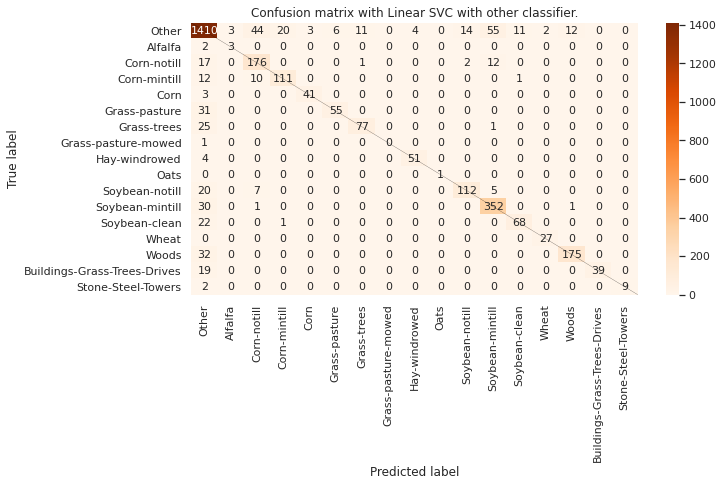

In [149]:
# Report classifier with other category
my_classification_report(pipe_svc_with,
                         X_test_with,
                         y_test_with,
                         (indiana_row, indiana_col),
                         label_to_category['indiana'].values(),
                         clf_name="Linear SVC with other")

The accuracy of the classifier does not look so low (0.86). However, as it can be seen from the confusion matrix and the f1 scores, all the categories but the `Other` category are not predicted at all by the LinearSCV classifier. The f1 score of each category is computed. Then the macro average f1 score is computed. It consist of an average of the f1 score of each category by the number of categories. The value of the macro average f1 score is **0.79**. It can be seen from the confusion matrix that the classifier only predicts some pixel belonging to the `Other` category (not even all of them).

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00         6
                 Corn-notill       0.91      0.91      0.91       223
                Corn-mintill       0.98      0.95      0.97       105
                        Corn       1.00      1.00      1.00        49
               Grass-pasture       1.00      0.99      0.99        69
                 Grass-trees       0.97      1.00      0.99       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00        67
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       0.96      0.88      0.92       157
             Soybean-mintill       0.95      0.97      0.96       384
               Soybean-clean       0.97      0.96      0.97        74
                       Wheat       1.00      1.00      1.00        27
                   

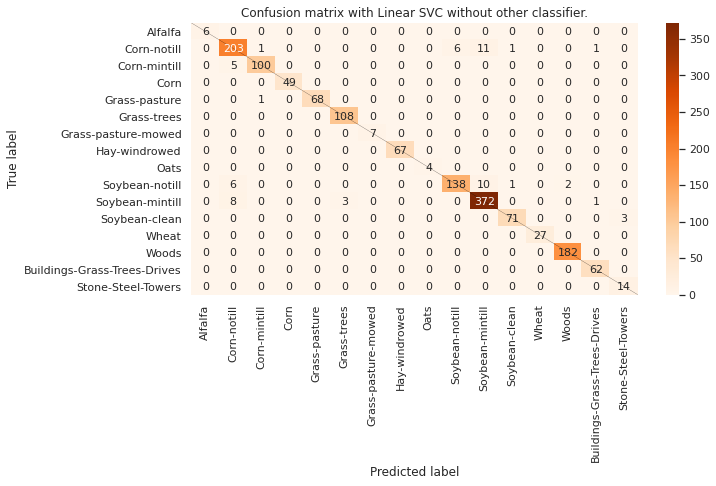

In [150]:
my_classification_report(pipe_svc_without,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         list(label_to_category['indiana'].values())[1:],
                         clf_name="Linear SVC without other")

In [151]:
print("Accuracy with: %1.2f, without: %1.2f"%(score_svc_with[0], score_svc_without[0]))
print("f1 macro average score with: %1.2f, without: %1.2f"%(score_svc_with[1], score_svc_without[1]))
print("f1 weigthed average score with: %1.2f, without: %1.2f"%(score_svc_with[2], score_svc_without[2]))

Accuracy with: 0.86, without: 0.96
f1 macro average score with: 0.79, without: 0.97
f1 weigthed average score with: 0.86, without: 0.96


Without the `Other` category, the classifier accuray is greater than the same classifier with the `Other` category (0.96). Another difference difference is the average macro f1 score. Now, the value of this score is **0.97** which is 20 pourcent greater than the previous one. It means the classifier is more able to predict any classes. It seems it is **worth to remove** the `Other` category in order to predict much better all the remaining categories. Moreover, the `Other` category means the pixels were not labelled. It makes sense to remove them as they can be considered as noise.

On the other hand, the LinearSVC classifier has a low accuracy in any case. Thus, let's double check with another classifier. 

#### RandomForest (Inherently multiclass)<a id="random_forest-1"></a>

[Table of content](#top-notebook)

Let's proceed to the test using the **RandomForest** classifier.

In [152]:
from sklearn.ensemble import RandomForestClassifier

##### Find best hyperparameters

In the **Grid Seach**, the parameters that vary are the following :
* **n_components**: The number of Principal Components.
* **n_estimators**: The number of decision trees in the forest.
* **class_weight**: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown. None means there is no weight between classes. There are all equal in the fitting process.

In [58]:
# With other
param_n_components = get_pca_components(X_train_with)

# Create pipe
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe_forest_with = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('pca', pca),
                                   ('random_forest', random_forest_clf)])

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
    'random_forest__class_weight': ["balanced", "balanced_subsample", None]
}

# Search
best_params = grid_search(pipe_forest_with, X_train_with, y_train_with, grid_params, n_jobs=2)

# Refit model with the best parameters
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(random_state=random_state,
                                           n_estimators=best_params['random_forest__n_estimators'],
                                           class_weight=best_params['random_forest__class_weight'])
pipe_forest_with = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('pca', pca),
                                   ('random_forest', random_forest_clf)])
pipe_forest_with.fit(X_train_with, y_train_with)

# Save
dump(pipe_forest_with, "models/pipe_forest_with.joblib")

---- Start search ----
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---- Search finished ----
Best parameter (CV score=0.973): 
{'pca__n_components': 35, 'random_forest__class_weight': 'balanced_subsample', 'random_forest__n_estimators': 2000}


['models/pipe_forest_with.joblib']

In [153]:
# Load
pipe_forest_with = load("models/pipe_forest_with.joblib")
display(pipe_forest_with)
# Evaluate
score_forest_with = evaluate_clf(pipe_forest_with, X_test_with, y_test_with)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=35, random_state=2727)),
                ('random_forest',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=2000,
                                        random_state=2727))])

Score: 0.979.
f1 macro score: 0.905.
f1 weighted score: 0.978.


In [60]:
%%time
# Without other
param_n_components = get_pca_components(X_train_without)

# Create pipe
pca = PCA(random_state=random_state)
random_forest_clf = RandomForestClassifier()
pipe_forest_without = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('pca', pca),
                                      ('random_forest', random_forest_clf)])

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'random_forest__n_estimators': [100, 500, 1000, 2000],
    'random_forest__class_weight': ["balanced", "balanced_subsample", None]
}

# Search
best_params = grid_search(pipe_forest_without, X_train_without, y_train_without, grid_params, n_jobs=2)

# Refit model without the best parameters
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
random_forest_clf = RandomForestClassifier(random_state=random_state,
                                           n_estimators=best_params['random_forest__n_estimators'],
                                           class_weight=best_params['random_forest__class_weight'])
pipe_forest_without = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('pca', pca),
                                      ('random_forest', random_forest_clf)])
pipe_forest_without.fit(X_train_without, y_train_without)

# Save
dump(pipe_forest_without, "models/pipe_forest_without.joblib")

---- Start search ----
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---- Search finished ----
Best parameter (CV score=0.998): 
{'pca__n_components': 30, 'random_forest__class_weight': None, 'random_forest__n_estimators': 100}
CPU times: user 7.66 s, sys: 2.2 s, total: 9.86 s
Wall time: 26min 40s


['models/pipe_forest_without.joblib']

In [154]:
# Load
pipe_forest_without = load("models/pipe_forest_without.joblib")
display(pipe_forest_without)
# Evaluate
score_forest_without = evaluate_clf(pipe_forest_without, X_test_without, y_test_without)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('random_forest', RandomForestClassifier(random_state=2727))])

Score: 0.999.
f1 macro score: 0.997.
f1 weighted score: 0.999.


##### Classification report

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

                       Other       0.97      0.99      0.98      1595
                     Alfalfa       1.00      0.60      0.75         5
                 Corn-notill       0.97      0.96      0.96       208
                Corn-mintill       0.98      0.97      0.97       134
                        Corn       1.00      0.93      0.96        44
               Grass-pasture       1.00      0.93      0.96        86
                 Grass-trees       1.00      0.96      0.98       103
         Grass-pasture-mowed       0.00      0.00      0.00         1
               Hay-windrowed       1.00      0.98      0.99        55
                        Oats       1.00      1.00      1.00         1
              Soybean-notill       0.99      0.99      0.99       144
             Soybean-mintill       0.98      0.98      0.98       384
               Soybean-clean       0.97      0.98      0.97        91
                   

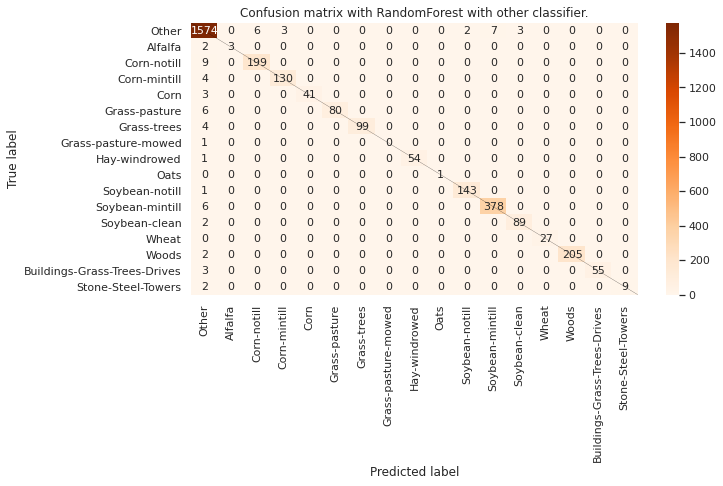

In [155]:
my_classification_report(pipe_forest_with,
                         X_test_with,
                         y_test_with,
                         (indiana_row, indiana_col),
                         label_to_category['indiana'].values(),
                         clf_name="RandomForest with other")

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00         6
                 Corn-notill       1.00      1.00      1.00       223
                Corn-mintill       1.00      1.00      1.00       105
                        Corn       1.00      1.00      1.00        49
               Grass-pasture       1.00      0.99      0.99        69
                 Grass-trees       1.00      1.00      1.00       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00        67
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       1.00      1.00      1.00       157
             Soybean-mintill       1.00      1.00      1.00       384
               Soybean-clean       0.99      1.00      0.99        74
                       Wheat       1.00      1.00      1.00        27
                   

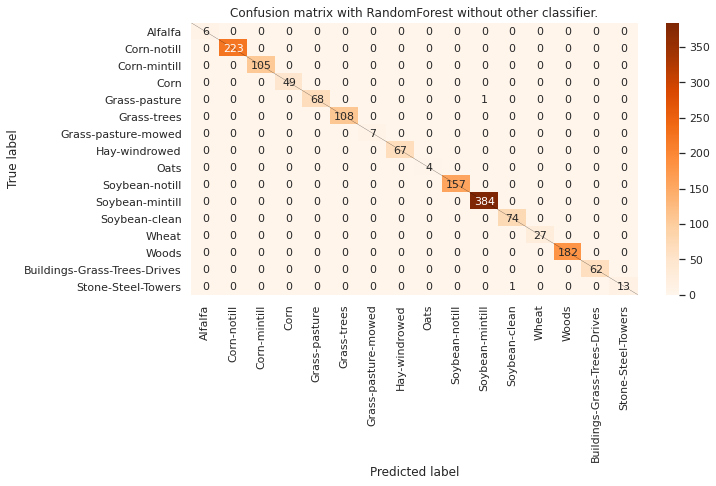

In [156]:
my_classification_report(pipe_forest_without,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         list(label_to_category['indiana'].values())[1:],
                         clf_name="RandomForest without other")

In [157]:
print("Accuracy with: %1.2f, without: %1.2f"%(score_forest_with[0], score_forest_without[0]))
print("f1 macro average score with: %1.2f, without: %1.2f"%(score_forest_with[1], score_forest_without[1]))
print("f1 weigthed average score with: %1.2f, without: %1.2f"%(score_forest_with[2], score_forest_without[2]))

Accuracy with: 0.98, without: 1.00
f1 macro average score with: 0.90, without: 1.00
f1 weigthed average score with: 0.98, without: 1.00


This time it is not as obvious as with the LinearSVC classifier. The accuracy and f1 weighted average score are equal to each other. But, the f1 macro average score is greater when the `Other` category does not exist. It can be seen in the confusion matrix. Once more, when the `Other` category does not exist the classifier is more able to predict every remaining categories.

Moreover, some small categories are shadowed by the `Other` category. As this category is very large, the classifiers tend to predict pixel belonging to the remaining categories as a pixel belonging to the `Other` category. It is not a wanted behavior at all. The classifier must be more sensible to small categories.


According to this experiment and its result, it makes sense to remove the classification of the `Other` category. This category is actually a non category. It is used for unlabelled pixels. Moreover, the performances of the classifiers are much worse because of this category. **It is decided to remove the pixels belonging to the `Other`** in the classification. The performances of the classifier will improve.

In [158]:
# Create new dictionnaries of categories
label_to_category_without = dict()
label_to_category_without['indiana'] = label_to_category['indiana'].copy()
label_to_category_without['salinas'] = label_to_category['salinas'].copy()

# Remove the other category
label_to_category_without['indiana'].pop(0)
label_to_category_without['salinas'].pop(0)

'Other'

### Indiana classification (bench)<a id="bench-classifier-indiana"></a>

[Table of content](#top-notebook)

![all text](https://scikit-learn.org/stable/_images/multi_org_chart.png)

The focus will be on the **multiclass classifiers**.

In this section, many experiments will be performed to **search the best classifier** for the 16 categories of the Indiana hyperspectral image. The problem is a multiclass classification. The multiclass classifier from sklearn will be used. There are three ways of classifying multiclass problem:
1. **One Versus One** (OvO): Split the multi-class dataset into multiple binary classification problems. Separate two classes at a time, ignoring the other data. Assign new points with majority voting rule.
2. **One Versus Rest/All** (OvR): As OvO, split the multi-class dataset into multiple binary classification problems. But separate the class from all other classes. A binary classifier is then trained on each binary classification problem. Prediction are made using the model that is the most confident.
3. **Inherently multiclass**: On the opposite of the two first kind of classifiers, this one works for multiclass directly. No extra strategy is needed. It predicts straightforwardly the class of a input.

The output of three ways is the same: predicting the category of the input.

#### LinearSVC (One Versus All)<a id="linear-svc-2"></a>
[Table of content](#top-notebook)

In [159]:
# Previously trained
pipe_svc_indiana = load("models/pipe_svc_without.joblib")
display(pipe_svc_indiana)
score_svc_indiana = evaluate_clf(pipe_svc_indiana, X_test_without, y_test_without)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('linearsvc', LinearSVC(C=1, random_state=2727))])

Score: 0.961.
f1 macro score: 0.974.
f1 weighted score: 0.961.


                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00         6
                 Corn-notill       0.91      0.91      0.91       223
                Corn-mintill       0.98      0.95      0.97       105
                        Corn       1.00      1.00      1.00        49
               Grass-pasture       1.00      0.99      0.99        69
                 Grass-trees       0.97      1.00      0.99       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00        67
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       0.96      0.88      0.92       157
             Soybean-mintill       0.95      0.97      0.96       384
               Soybean-clean       0.97      0.96      0.97        74
                       Wheat       1.00      1.00      1.00        27
                   

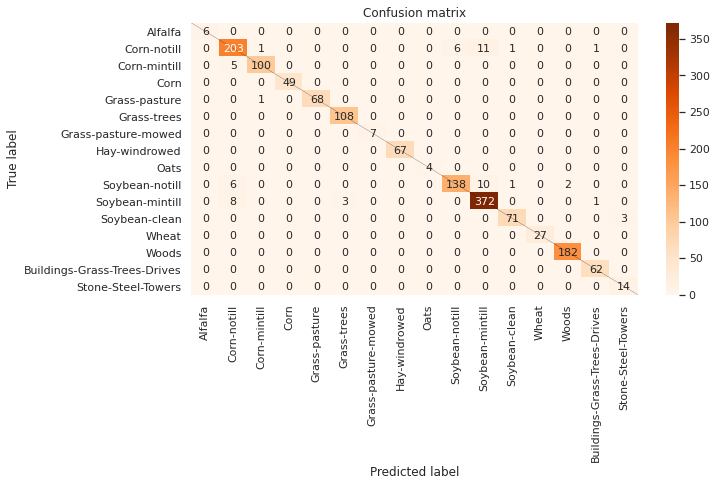

In [160]:
my_classification_report(pipe_svc_indiana,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         label_to_category_without['indiana'].values())

#### Interpretation

With the **LinearSVC**(One versus All), the results are pretty satisfying because the mean accuracy, F1 score macro, and F1 score weighted are all above 0.96. However, the prediction of **Stone-still-towers** are a bit disapointing since it has the lowest accuracy, the model misinterpreted 3 Soybean-clean as Stone-still-towers.

#### RandomForest (Inherently multiclass)<a id="random_forest-2-indiana"></a>
[Table of content](#top-notebook)

In [161]:
# Previously trained
pipe_forest_indiana = load("models/pipe_forest_without.joblib")
display(pipe_forest_indiana)
score_forest_indiana = evaluate_clf(pipe_forest_indiana, X_test_without, y_test_without)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('random_forest', RandomForestClassifier(random_state=2727))])

Score: 0.999.
f1 macro score: 0.997.
f1 weighted score: 0.999.


                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00         6
                 Corn-notill       1.00      1.00      1.00       223
                Corn-mintill       1.00      1.00      1.00       105
                        Corn       1.00      1.00      1.00        49
               Grass-pasture       1.00      0.99      0.99        69
                 Grass-trees       1.00      1.00      1.00       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00        67
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       1.00      1.00      1.00       157
             Soybean-mintill       1.00      1.00      1.00       384
               Soybean-clean       0.99      1.00      0.99        74
                       Wheat       1.00      1.00      1.00        27
                   

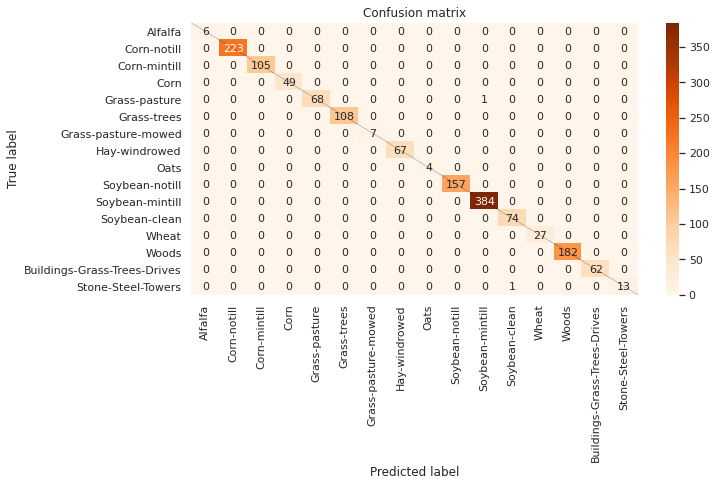

In [162]:
my_classification_report(pipe_forest_indiana,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         label_to_category_without['indiana'].values())

#### Interpretation

With the **Random Forest algorithm**, the results are incredibly satisfying. Indeed, the mean accuracy, F1 score macro and F1 score weighted are in the vicinity of 1. Only 2 mistakes were made by the model :
* a Soybean-mintill mistaken for a grass-pasture.
* a Soybean-clean mistaken for a Stone-Steel-Towers.


#### K-nearest neighbors (Inherently multiclass)<a id="k-nearest-2"></a>
[Table of content](#top-notebook)

In [163]:
from sklearn.neighbors import KNeighborsClassifier

In the **Grid Seach**, the parameters that vary are the following :
* **n_components**: The number of Principal Components.
* **n_neighbors**: Number of neighbors to use by default for kneighbors queries.
* **weights**:
    * `uniform`: uniform weights. All points in each neighborhood are weighted equally.
    * `distance`: weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
* **leaf_size** : Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.
* **algorithm** : Algorithm used to compute the nearest neighbors.
    * `ball-tree` and `kd-tree` for fast generalized N-point problems
    * `brute` for bruteforce search.

In [71]:
%%time

param_n_components = get_pca_components(X_train_without)

# Create pipe
pca = PCA(random_state=random_state)
k_neighbors_clf = KNeighborsClassifier()
pipe_knn_indiana = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('pca', pca),
                                   ('knn', k_neighbors_clf)])

# Create the grid search
grid_params = {
    'knn__n_neighbors' : [3,4,5,6,7],
    'knn__weights' : ['distance', 'uniform'],
    'knn__algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 30 , 50],
    'pca__n_components': param_n_components,
}

# Search
best_params = grid_search(pipe_knn_indiana, X_train_without, y_train_without, grid_params)

# Refit model with the best parameters
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])

k_neighbors_clf = KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'],
                                       weights=best_params['knn__weights'],
                                       algorithm=best_params['knn__algorithm'],
                                       leaf_size=best_params['knn__leaf_size'])

pipe_knn_indiana = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('pca', pca),
                                   ('knn', k_neighbors_clf)])
pipe_knn_indiana.fit(X_train_without, y_train_without)

# Save
dump(pipe_knn_indiana, "models/pipe_knn_indiana.joblib")

---- Start search ----
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
---- Search finished ----
Best parameter (CV score=0.992): 
{'knn__algorithm': 'ball_tree', 'knn__leaf_size': 10, 'knn__n_neighbors': 4, 'knn__weights': 'distance', 'pca__n_components': 30}
CPU times: user 7.83 s, sys: 3.25 s, total: 11.1 s
Wall time: 1min 41s


['models/pipe_knn_indiana.joblib']

In [164]:
# Previously trained
pipe_knn_indiana = load("models/pipe_knn_indiana.joblib")
display(pipe_knn_indiana)
score_knn_indiana = evaluate_clf(pipe_knn_indiana, X_test_without, y_test_without)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=10,
                                      n_neighbors=4, weights='distance'))])

Score: 0.996.
f1 macro score: 0.998.
f1 weighted score: 0.996.


                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00         6
                 Corn-notill       1.00      1.00      1.00       223
                Corn-mintill       1.00      1.00      1.00       105
                        Corn       1.00      1.00      1.00        49
               Grass-pasture       1.00      1.00      1.00        69
                 Grass-trees       0.99      1.00      1.00       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00        67
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       0.99      0.98      0.99       157
             Soybean-mintill       0.99      1.00      0.99       384
               Soybean-clean       1.00      1.00      1.00        74
                       Wheat       1.00      1.00      1.00        27
                   

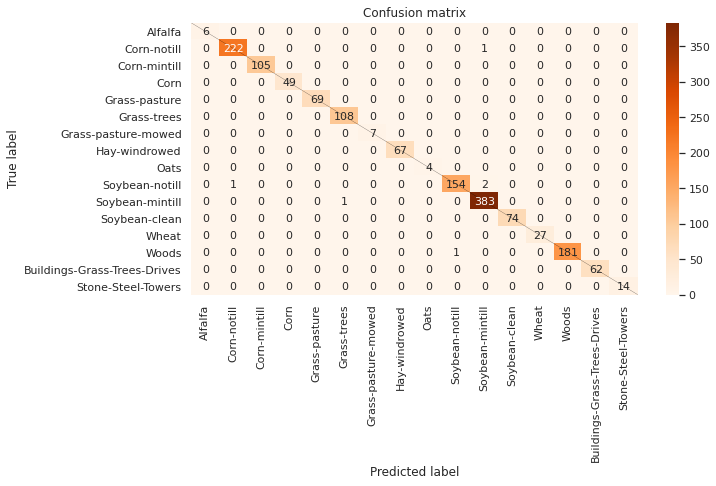

In [165]:
my_classification_report(pipe_knn_indiana,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         label_to_category_without['indiana'].values())

#### Interpretation

With the **K nearest neighbors** algorithm, the results are very satisfying. Indeed, the mean accuracy, F1 score macro and F1 score weighted are in the vicinity of 1. Indeed, only a few mistakes were made by the model.


#### SVC (One Versus One)<a id="svc-2-indiana"></a>
[Table of content](#top-notebook)

In [166]:
from sklearn.svm import SVC

In the **Grid Seach**, the parameters that vary are the following :
* **n_components**: The number of Principal Components.
* **max_iter**: The maximum number of iterations to be run for the SVC.
* **C**: The regularization parameter. The strength of the regularization is inversely proportional to C and must be strictly positive.
* **kernel** : Specifies the kernel type to be used in the algorithm.
    * `linear`
    * `poly`
    * `rbf`
    * `sigmoid`
* **class_weight** :
    * `None`
    * `balanced`: this mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as $\frac{n\_samples}{n\_classes *  np.bincount(y)}$

In [75]:
%%time
param_n_components = get_pca_components(X_train_without)

# Create pipe
pca = PCA(random_state=random_state)
svc = SVC(random_state=random_state)
pipe_svc2_indiana = Pipeline(steps=[('scaler', StandardScaler()),
                                    ('pca', pca),
                                    ('svc', svc)])

# Create the grid search
grid_params = {
    'pca__n_components': param_n_components,
    'svc__max_iter': max_iter_range,
    'svc__C': [1, 100, 250, 500],
    'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__class_weight' : ['balanced', None],
}

# Search
best_params = grid_search(pipe_svc2_indiana, X_train_without, y_train_without, grid_params)


# Refit model without the best parameters
svc = SVC(random_state=random_state,
          max_iter=best_params['svc__max_iter'],
          C=best_params['svc__C'],
          kernel=best_params['svc__kernel'],
          class_weight=best_params['svc__class_weight'])
pca = PCA(random_state=random_state, n_components=best_params['pca__n_components'])
pipe_svc2_indiana = Pipeline(steps=[('scaler', StandardScaler()),
                                    ('pca', pca),
                                    ('svc', svc)])
pipe_svc2_indiana.fit(X_train_without, y_train_without)

# Save
dump(pipe_svc2_indiana, "models/pipe_svc2_indiana.joblib") 

---- Start search ----
Fitting 5 folds for each of 512 candidates, totalling 2560 fits


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


---- Search finished ----
Best parameter (CV score=0.999): 
{'pca__n_components': 30, 'svc__C': 500, 'svc__class_weight': None, 'svc__kernel': 'rbf', 'svc__max_iter': 3000}
CPU times: user 10.5 s, sys: 4.82 s, total: 15.3 s
Wall time: 12min 13s


/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


['models/pipe_svc2_indiana.joblib']

In [167]:
# Previously trained
pipe_svc2_indiana = load("models/pipe_svc2_indiana.joblib")
display(pipe_svc2_indiana)
score_svc2_indiana = evaluate_clf(pipe_svc2_indiana, X_test_without, y_test_without)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('svc', SVC(C=500, max_iter=3000, random_state=2727))])

Score: 0.999.
f1 macro score: 0.997.
f1 weighted score: 0.999.


                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00         6
                 Corn-notill       1.00      1.00      1.00       223
                Corn-mintill       1.00      1.00      1.00       105
                        Corn       1.00      1.00      1.00        49
               Grass-pasture       1.00      1.00      1.00        69
                 Grass-trees       1.00      1.00      1.00       108
         Grass-pasture-mowed       1.00      1.00      1.00         7
               Hay-windrowed       1.00      1.00      1.00        67
                        Oats       1.00      1.00      1.00         4
              Soybean-notill       1.00      1.00      1.00       157
             Soybean-mintill       1.00      1.00      1.00       384
               Soybean-clean       1.00      0.99      0.99        74
                       Wheat       1.00      1.00      1.00        27
                   

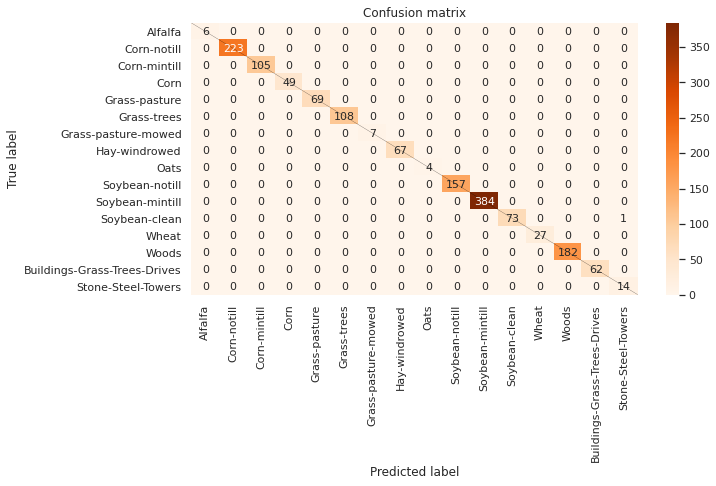

In [168]:
my_classification_report(pipe_svc2_indiana,
                         X_test_without,
                         y_test_without,
                         (indiana_row, indiana_col),
                         label_to_category_without['indiana'].values())

#### Interpretation

With the **SVC**, the results are the best ones so far. Only 1 mistake were made by the model :
* a Soybean-clean mistaken for a Stone-Steel-Towers. 

This mistake is somewhat recurrent because it also appeared in the results of the LinearSVC.
It is an almost perfect result.

### Recap of all classifiers <a id="recap-indiana"></a>
[Table of content](#top-notebook)

Here, we will do a recap of the different classifiers used and show a benchmark.

Let's quickly add a constraint of time.

In [197]:
%%time
pipe_svc_indiana.predict(X_indiana_without)

CPU times: user 47.9 ms, sys: 22.4 ms, total: 70.3 ms
Wall time: 25 ms


array([ 3,  3,  3, ..., 10, 10, 10], dtype=uint8)

In [198]:
%%time
pipe_forest_indiana.predict(X_indiana_without)

CPU times: user 380 ms, sys: 229 ms, total: 609 ms
Wall time: 192 ms


array([ 3,  3,  3, ..., 10, 10, 10], dtype=uint8)

In [171]:
%%time
pipe_knn_indiana.predict(X_indiana_without)

CPU times: user 498 ms, sys: 214 ms, total: 713 ms
Wall time: 301 ms


array([ 3,  3,  3, ..., 10, 10, 10], dtype=uint8)

In [172]:
%%time
pipe_svc2_indiana.predict(X_indiana_without)

CPU times: user 852 ms, sys: 222 ms, total: 1.07 s
Wall time: 657 ms


array([ 3,  3,  3, ..., 10, 10, 10], dtype=uint8)

In [173]:
# From the previous cell
time = [25, 192, 301, 657]
time

[25.2, 269, 301, 657]

In [179]:
score_svc_indiana = score_svc_indiana + (time[0],)
score_forest_indiana = score_forest_indiana + (time[1],)
score_knn_indiana = score_knn_indiana + (time[2],)
score_svc2_indiana = score_svc2_indiana + (time[3],)

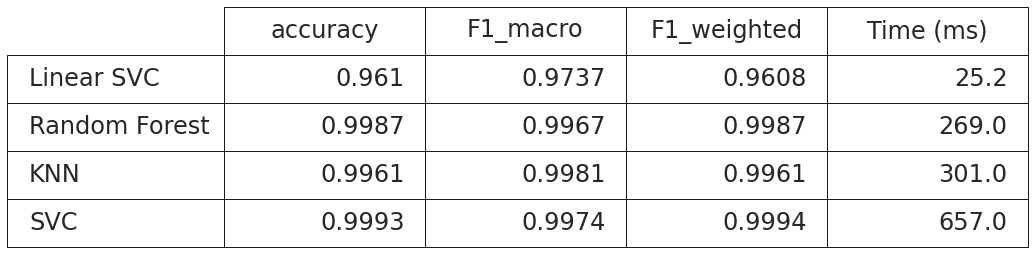

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111)
y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]    
col_labels = ['accuracy', 'F1_macro', 'F1_weighted', 'Time (ms)']
row_labels = ['Linear SVC', 'Random Forest', 'KNN', 'SVC']
table_vals = [np.around(np.array(score_svc_indiana), decimals=4),
              np.around(np.array(score_forest_indiana), decimals=4),
              np.around(np.array(score_knn_indiana), decimals=4),
              np.around(np.array(score_svc2_indiana), decimals=4)]

# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.15] * 4,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)
plt.axis('off')
# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

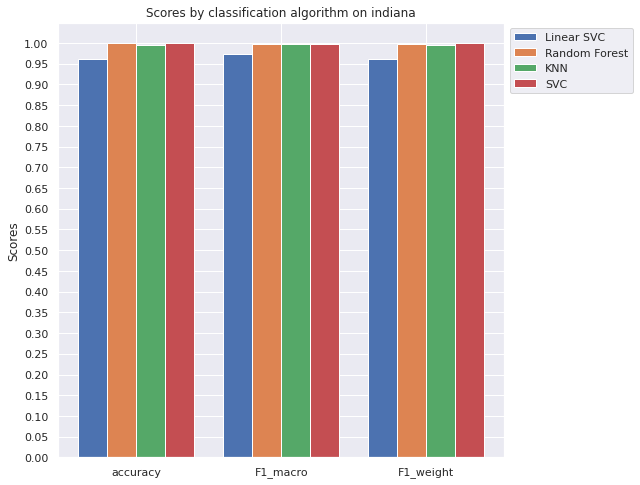

In [184]:
from matplotlib.pyplot import figure

N = 3
figure(figsize=(8,8))
ind = np.arange(N) 
width = 0.2       
plt.bar(ind, score_svc_indiana[:-1], width, label='Linear SVC')
plt.bar(ind + width, score_forest_indiana[:-1], width, label='Random Forest')
plt.bar(ind + 2 * width, score_knn_indiana[:-1], width, label='KNN')
plt.bar(ind + 3 * width, score_svc2_indiana[:-1], width, label='SVC')

plt.ylabel('Scores')
plt.title('Scores by classification algorithm on indiana')

plt.xticks(ind + width*1.5, ('accuracy', 'F1_macro', 'F1_weight'))
plt.yticks(np.arange(0.0, 1.05, 0.05))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

As we can see on the table and graph above, the scores of the **Linear SVC** is below the rest. The **random forest** and the **SVC** are the best classifiers. The **K-neighbors** classifier looks very efficient but not as acurate as the top 2 classifiers in terms of accuracy and f1 score. kneighborsclassifier.

Moreover, in the case of a **time constraint**, the random forest classifier is the best classifier compromising efficiency, accuracy and speed. 

But which classifier between random forest and SVC should be taken? The current problematic is to find the most accurate **and generic** classifier for hyperspectral pixels classification. The most accurate classifiers were already found. But are they generic? We have the chance to have a second hyperspectral image `Salinas` to test the genericity of the two classifiers. The best classifier will be selected according to its performance with the other hyperspectral image.

### Salinas classification<a id="salinas-classification"></a>

[Table of content](#top-notebook)

In this section, we will use the previous best algorithms for Indiana on Salinas : **SVC** and **Random Forest**. We are going to use the previously found best hyperparameters directly on the Salinas data. In case of a poor result, we will perform another Grid Search on the Salinas data with the different algorithms in order the find the optimal parameters for this image.

Same as before, the `other` category needs to be removed while performing the **SVC** algorithm on the Salinas data.

In [185]:
# Remove pixels with the unknown category (category 0)
without_indices_salinas = np.where(y_salinas!=0)[0]
# Take the preprocessed image (blur)
X_salinas_without = X_salinas_blur[without_indices_salinas]
y_salinas_without = y_salinas[without_indices_salinas]
X_salinas_without.shape, y_salinas_without.shape

((54129, 204), (54129,))

In [186]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X_salinas_without, 
                                                                                    y_salinas_without, 
                                                                                    test_size=0.15,
                                                                                    random_state=random_state)

X_train_without.shape, y_train_without.shape, X_test_without.shape, y_test_without.shape

((46009, 204), (46009,), (8120, 204), (8120,))

#### SVC (One Versus One)<a id="svc-2-salinas"></a>
[Table of content](#top-notebook)

In [187]:
pca = PCA(random_state=random_state,
          n_components=pipe_svc2_indiana['pca'].n_components)

svc = SVC(random_state=random_state,
          max_iter=pipe_svc2_indiana['svc'].max_iter,
          C=pipe_svc2_indiana['svc'].C,
          kernel=pipe_svc2_indiana['svc'].kernel, # rbf
          class_weight=pipe_svc2_indiana['svc'].class_weight) # None

pipe_svc2_salinas = Pipeline(steps=[('scaler', StandardScaler()),
                                    ('pca', pca),
                                    ('svc', svc)])
pipe_svc2_salinas.fit(X_train_without, y_train_without)

/home/li0nmo0se/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('svc', SVC(C=500, max_iter=3000, random_state=2727))])

In [188]:
score_svc2_salinas = evaluate_clf(pipe_svc2_salinas, X_test_without, y_test_without)

Score: 0.998.
f1 macro score: 0.999.
f1 weighted score: 0.998.


                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      1.00      1.00       291
    Brocoli_green_weeds_2       1.00      1.00      1.00       559
                   Fallow       1.00      1.00      1.00       278
        Fallow_rough_plow       1.00      1.00      1.00       235
            Fallow_smooth       1.00      1.00      1.00       422
                  Stubble       1.00      1.00      1.00       621
                   Celery       1.00      1.00      1.00       549
         Grapes_untrained       1.00      0.99      1.00      1604
     Soil_vinyard_develop       1.00      1.00      1.00       954
Corn_senesced_green_weeds       1.00      1.00      1.00       488
      Lettuce_romaine_4wk       1.00      1.00      1.00       159
      Lettuce_romaine_5wk       1.00      1.00      1.00       292
      Lettuce_romaine_6wk       1.00      1.00      1.00       129
      Lettuce_romaine_7wk       1.00      1.00      1.00     

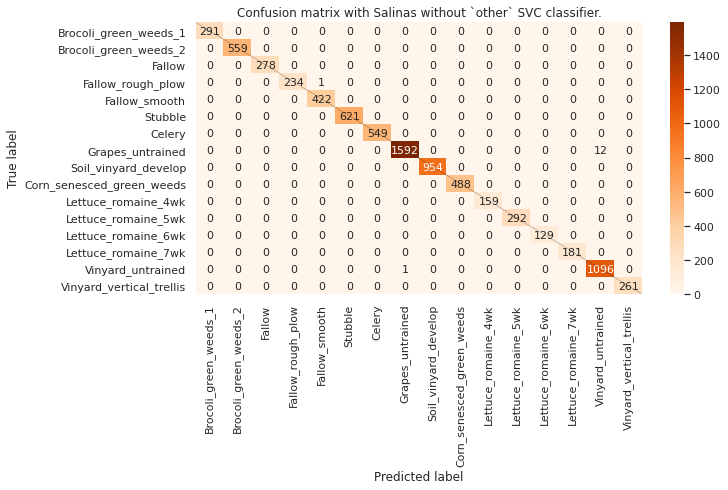

In [189]:
my_classification_report(pipe_svc2_salinas,
                         X_test_without,
                         y_test_without,
                         (salinas_row, salinas_col),
                         label_to_category_without['salinas'].values(),
                         clf_name="Salinas without `other` SVC")

#### Interpretation

Using the SVC algorithm, the results can be considered as very promising already considering the fact that there are 5 times more pixels on the Salinas data. There are only a few mispredictions.
Most of the mispredictions come from the confusion between `vinyard_untrained` and `grapes_untrained` which is an understanble mistake since they have similarities.

#### Random Forest<a id="random_forest-2-salinas"></a>
[Table of content](#top-notebook)

In [190]:
pca = PCA(random_state=pipe_forest_indiana['pca'].random_state,
          n_components=pipe_forest_indiana['pca'].n_components)
random_forest_clf = RandomForestClassifier(random_state=pipe_forest_indiana['random_forest'].random_state,
                                           n_estimators=pipe_forest_indiana['random_forest'].n_estimators,
                                           class_weight=pipe_forest_indiana['random_forest'].class_weight)
pipe_forest_salinas = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('pca', pca),
                                      ('random_forest', random_forest_clf)])
pipe_forest_salinas.fit(X_train_without, y_train_without)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=30, random_state=2727)),
                ('random_forest', RandomForestClassifier(random_state=2727))])

In [191]:
score_forest_salinas = evaluate_clf(pipe_forest_salinas, X_test_without, y_test_without)

Score: 1.000.
f1 macro score: 1.000.
f1 weighted score: 1.000.


                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      1.00      1.00       291
    Brocoli_green_weeds_2       1.00      1.00      1.00       559
                   Fallow       1.00      1.00      1.00       278
        Fallow_rough_plow       1.00      1.00      1.00       235
            Fallow_smooth       1.00      1.00      1.00       422
                  Stubble       1.00      1.00      1.00       621
                   Celery       1.00      1.00      1.00       549
         Grapes_untrained       1.00      1.00      1.00      1604
     Soil_vinyard_develop       1.00      1.00      1.00       954
Corn_senesced_green_weeds       1.00      1.00      1.00       488
      Lettuce_romaine_4wk       1.00      1.00      1.00       159
      Lettuce_romaine_5wk       1.00      1.00      1.00       292
      Lettuce_romaine_6wk       1.00      1.00      1.00       129
      Lettuce_romaine_7wk       1.00      1.00      1.00     

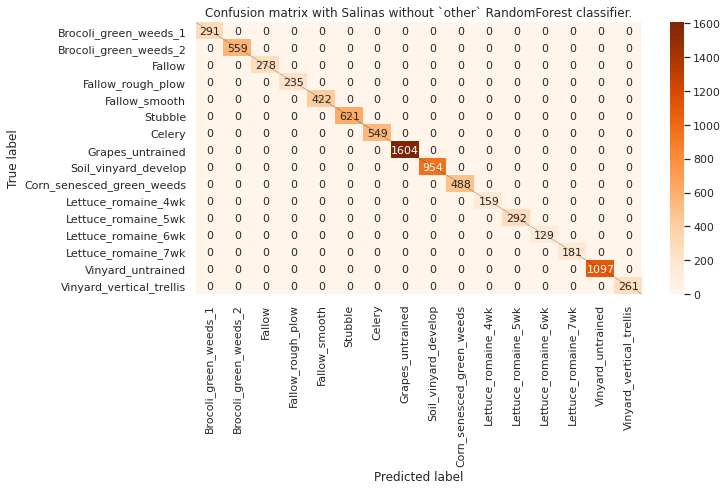

In [192]:
my_classification_report(pipe_forest_salinas,
                         X_test_without,
                         y_test_without,
                         (salinas_row, salinas_col),
                         label_to_category_without['salinas'].values(),
                         clf_name="Salinas without `other` RandomForest")

#### Interpretation

Using the **Random Forest** algorithm, it is the best result we had since there is no mistake. The classifier is no longer confused between `vinyard_untrained` and `grapes_untrained`. The random forest classifier **predicts every classes well equally** even if the `class_weigth` parameter is not used.

### Recap of salinas classifiers <a id="recap-salinas"></a>
[Table of content](#top-notebook)

We will compare the different classifiers used for the salinas image.

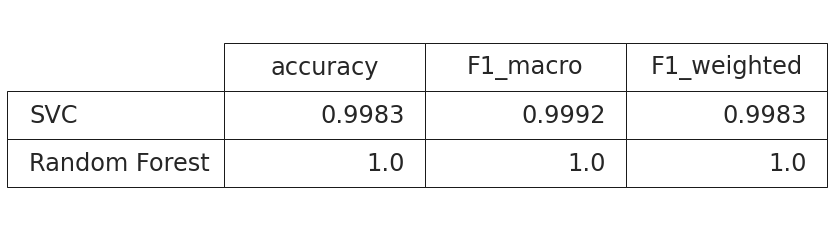

In [193]:
fig = plt.figure()
ax = fig.add_subplot(111)
y = [1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1]    
col_labels = ['accuracy', 'F1_macro', 'F1_weighted']
row_labels = ['SVC', 'Random Forest']
table_vals = [np.around(np.array(score_svc2_salinas), decimals=4),
              np.around(np.array(score_forest_salinas), decimals=4)]

# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.15] * 3,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)
plt.axis('off')
# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

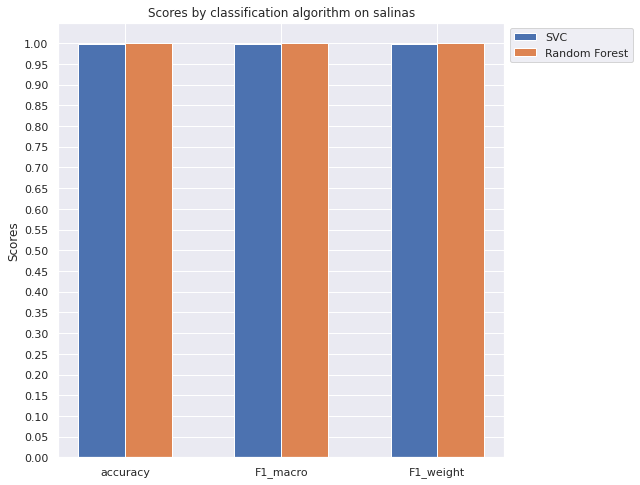

In [194]:
from matplotlib.pyplot import figure

N = 3
figure(figsize=(8,8))
ind = np.arange(N) 
width = 0.3       
plt.bar(ind, score_svc2_salinas, width, label='SVC')
plt.bar(ind + width, score_forest_salinas, width, label='Random Forest')

plt.ylabel('Scores')
plt.title('Scores by classification algorithm on salinas')

plt.xticks(ind + width/2, ('accuracy', 'F1_macro', 'F1_weight'))
plt.yticks(np.arange(0.0, 1.05, 0.05))

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The **Random forest** seems to be the most trustworthy classifier for the salinas image. As the score is really close to 1, there is not much difference, but we can see a slight better score for the **Random forest** algorithm. The random forest has made no mistake on the test data compared to the SVC which made a few mispredictions.

## Impact of the gaussian blur<a id="impact-gauss-blur"></a>

[Table of content](#top-notebook)

In this section, the strength of a gaussian blur as a preprocessing is going to be prove. The accuracy of the same classifier will be evaluated over more or less blur input hyperspectral image.

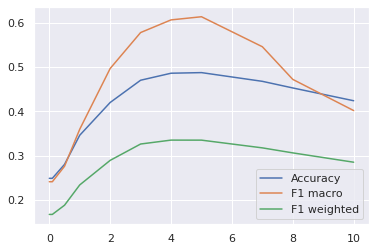

In [240]:
sigmas = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 7, 8, 10]
scores = []

for sigma in sigmas:
    im_blur = gaussian(X_indiana, sigma, multichannel=True)
    im_blur = im_blur.reshape((-1, indiana_dim)) # Flatten (keep the bandwidths)
    # For this example, it is not required to remove `other` category
    scores.append(np.array(evaluate_clf(pipe_forest_indiana, im_blur, y_indiana, must_print=False)))
scores = np.array(scores)

plt.plot(sigmas, scores)
plt.legend(["Accuracy", "F1 macro", "F1 weighted"])
plt.show()

In [242]:
# Accuracy
print(f"Best sigma for best accuracy: {sigmas[np.argmax(scores[:, 0])]}")
# F1 score macro
print(f"Best sigma for best f1 score macro: {sigmas[np.argmax(scores[:, 1])]}")
# F1 score weighted
print(f"Best sigma for best f1 score weighted: {sigmas[np.argmax(scores[:, 2])]}")

Best sigma for best accuracy: 5
Best sigma for best f1 score macro: 5
Best sigma for best f1 score weighted: 4


**Applying a gaussian blur** on the hyperspectral input image **improves significantly the scores** of any classifiers.

Overall, a gaussian blur with sigma equals to 5 seems to be the best parameter. That is why it has been used throughout the whole notebook. It gives the best preprocessing for the hyperspectral image classification.

## Performance of the best classifier<a id="performance-best-classifier"></a>

[Table of content](#top-notebook)

Let's make a recap of all the experiments that have been made so far. On the first experimentation with the `Indiana` hyperspectral image, two very accurate classifiers were found:
* **SVC**
* **RandomForest**

However, these classifiers were so equals in terms of accuracy that it was impossible to pick one over the other one. Moreover, the goal is to find an accurate and generic classifier. Thus, a second experiment with these two classifiers was performed this time with the `Salinas` image. Through this experiment, we found out that the random forest algorithm works slightly better.

Our conclusion is that the best classifier is the **random forest** classifier because it is very accurate and the most generic.

In [199]:
def remove_category(y, category=0):
    """
    Remove the indices of a specific category
    
    Parameters
    ----------
    y : numpy.ndarray
        List of labels
    category: int, default: 0
        Integer representing a category

    Returns
    -------
    numpy.ndarray
        Indices of y without the given category
    """
    return np.where(y!=category)[0]

In [200]:
def predict_hyperspectral(im, category_set, class_pixels):
    """
    Predict the labels of an hyperspectral image
    
    Parameters
    ----------
    im : numpy.ndarray
        The hyperspectral image to predict
    category_set: str
        Set of categories (indiana or salinas). Categories from the indiana hyperspectral image
        or from the salinas hyperspectral image
    class_pixels: numpy.ndarray
        Indices of pixel to predict. Useful to remove the pixel not belonging to any category.
    
    Returns
    -------
    numpy.ndarray
        Labels predicted for the input hyperspectral image.
    """
    row, col, dim = im.shape
    # Preprocessing
    im_blur = gaussian(im, sigma=5, multichannel=True) # Gaussian blur
    im_blur = im_blur.reshape((-1, dim)) # Flatten (keep the band)
    im_blur_without = im_blur[class_pixels] # Remove no category pixels

    # Prediction
    if category_set == "indiana":
        # Pipe already fit
        pipe = pipe_forest_indiana
    elif category_set == "salinas":
        # Pipe already fit
        pipe = pipe_forest_salinas
    else:
        raise ValueError("Unknown category set. Must be `indiana` or `salinas`")
    
    y_pred = pipe.predict(im_blur_without)
    
    # Result
    y = np.zeros((row * col))
    y[class_pixels] = y_pred
    
    return y

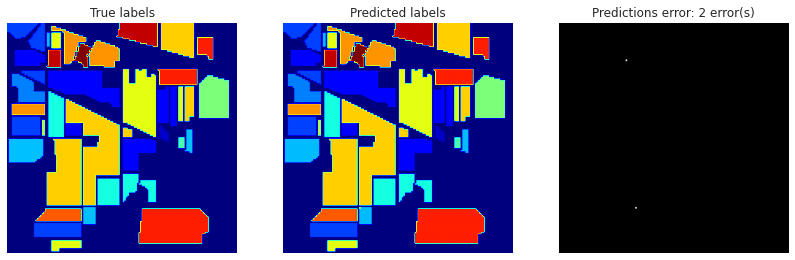

In [201]:
X_indiana = X_indiana.reshape((indiana_row, indiana_col, indiana_dim))
y_pred_indiana = predict_hyperspectral(X_indiana, 'indiana', remove_category(y_indiana))

plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.axis('off')
plt.title("True labels")
plt.imshow(y_indiana.reshape((indiana_row, indiana_col)), cmap='jet')
plt.subplot(132)
plt.title("Predicted labels")
plt.axis('off')
plt.imshow(y_pred_indiana.reshape((indiana_row, indiana_col)), cmap='jet')
plt.subplot(133)
uniques = np.unique(y_indiana!=y_pred_indiana, return_counts=True)
if len(uniques[0]) == 1: # No error
    nb_error = "0"
else:
    nb_error = str(uniques[1][1])
plt.title("Predictions error: " + nb_error + " error(s)")
plt.axis('off')
plt.imshow((y_indiana!=y_pred_indiana).reshape((indiana_row, indiana_col)), cmap='gray')
plt.show()

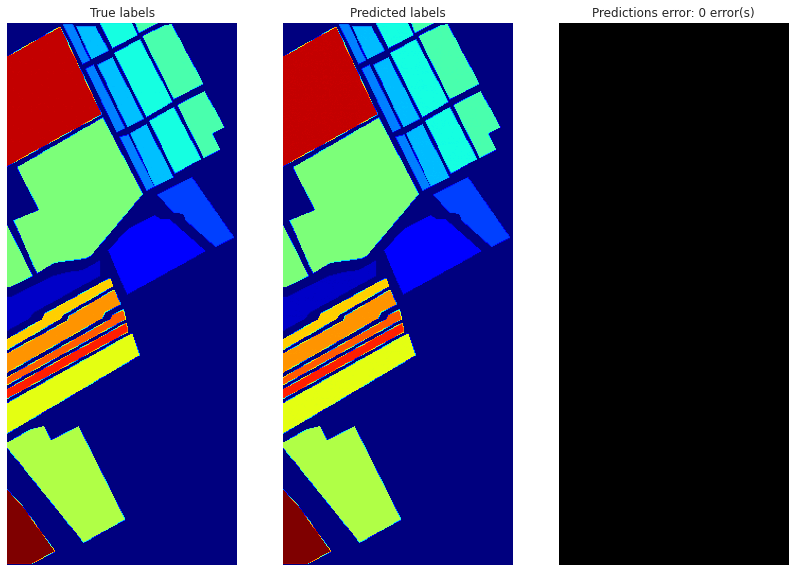

In [202]:
X_salinas = X_salinas.reshape((salinas_row, salinas_col, salinas_dim))
y_pred_salinas = predict_hyperspectral(X_salinas, 'salinas', remove_category(y_salinas))

plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.axis('off')
plt.title("True labels")
plt.imshow(y_salinas.reshape((salinas_row, salinas_col)), cmap='jet')
plt.subplot(132)
plt.title("Predicted labels")
plt.axis('off')
plt.imshow(y_pred_salinas.reshape((salinas_row, salinas_col)), cmap='jet')
plt.subplot(133)
uniques = np.unique(y_salinas!=y_pred_salinas, return_counts=True)
if len(uniques[0]) == 1: # No error
    nb_error = "0"
else:
    nb_error = str(uniques[1][1])
plt.title("Predictions error: " + nb_error + " error(s)")
plt.axis('off')
plt.imshow((y_salinas!=y_pred_salinas).reshape((salinas_row, salinas_col)), cmap='gray')
plt.show()

For the `indiana` prediction, there were 2 errors. For the `salinas` prediction, there was no error. The random forest classifier is very accurate and very generic. It works perfectly on the two different hyperspectral data.

As a reminder, if we had kept the `other` category the score will be still high but not as high as now.

Moreover, the classifiers did fit partially (\~85% of the pixels) the two input. The important point is that within the not fit pixels (\~15%) the classifiers still predict them accurately.

## Tasks distribution<a id="tasks-distribution"></a>

[Table of content](#top-notebook)

|                     | Louis               | Ilan                   | Raphael             |
| :------------------ | :------------------ | :--------------------: | ------------------: |
| Preprocessing       |                     | X                      |                     |
| Bench (SVC)         | X                   |                        | X                   |
| Bench (KNN)         |                     |                        | X                   |
| Bench (Linear SVC)  | X                   |                        | X                   |
| Bench (Random forest) | X                 | X                      |                     |
| PCA                 | X                   | X                      | X                   |
| Explanations in notebook | X              | X                      |                     |
| Classification API  |                     | X                      |                     |